In [ ]:
PRICE_CSV = "/content/de_power_data.csv"
LOAD_CSV = "/content/de_load_data.csv"
RES_CSV = "/content/de_res_actual.csv"

In [ ]:
# STEP 1 – Install required packages (Colab)

!pip install -q pandas numpy matplotlib scikit-learn google-generativeai requests python-dateutil

In [ ]:
# STEP 1 – Imports and basic configuration

import os

# LLM library (we will configure it later)
import google.generativeai as genai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make plots appear inline
%matplotlib inline

# Pandas display options for easier debugging
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)

# --- Project-level configuration (we will extend this later) ---

CONFIG = {
    "project_name": "de_power_ai_agent",
    "country": "DE-LU",  # main bidding zone
    "timezone": "Europe/Berlin",
    "data_dir": "/content/data",  # Colab's working directory
}

# Ensure data directory exists
os.makedirs(CONFIG["data_dir"], exist_ok=True)

print("Environment initialized.")
print("Project:", CONFIG["project_name"])
print("Data directory:", CONFIG["data_dir"])

Environment initialized.
Project: de_power_ai_agent
Data directory: /content/data


In [ ]:
# STEP 1 – Quick version and numeric sanity check

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

arr = np.array([1, 2, 3])
print("Test array:", arr, "sum:", arr.sum())

Pandas version: 2.2.2
NumPy version: 2.0.2
Test array: [1 2 3] sum: 6


In [ ]:
# STEP 2 – Load German day-ahead power data (SMARD CSV)

import os

# If you renamed your file differently, update this variable
csv_filename = "de_power_data.csv"
csv_path = os.path.join("/content", csv_filename)

# Verify the file exists
if not os.path.exists(csv_path):
    raise FileNotFoundError(
        f"CSV file '{csv_filename}' not found in /content/. " "Check the upload and filename."
    )

# Attempt to read CSV with automatic separator detection
try:
    df_raw = pd.read_csv(csv_path)
except Exception:
    # fallback if SMARD uses semicolon separator
    df_raw = pd.read_csv(csv_path, sep=";", engine="python")

print("Raw DataFrame loaded successfully.")
print("Shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
df_raw.head()

Raw DataFrame loaded successfully.
Shape: (264, 1)
Columns: ['Start date;End date;Germany/Luxembourg [€/MWh] Calculated resolutions;∅ DE/LU neighbours [€/MWh] Calculated resolutions;Belgium [€/MWh] Calculated resolutions;Denmark 1 [€/MWh] Calculated resolutions;Denmark 2 [€/MWh] Calculated resolutions;France [€/MWh] Calculated resolutions;Netherlands [€/MWh] Calculated resolutions;Norway 2 [€/MWh] Calculated resolutions;Austria [€/MWh] Calculated resolutions;Poland [€/MWh] Calculated resolutions;Sweden 4 [€/MWh] Calculated resolutions;Switzerland [€/MWh] Calculated resolutions;Czech Republic [€/MWh] Calculated resolutions;DE/AT/LU [€/MWh] Calculated resolutions;Northern Italy [€/MWh] Calculated resolutions;Slovenia [€/MWh] Calculated resolutions;Hungary [€/MWh] Calculated resolutions']


Start date;End date;Germany/Luxembourg [€/MWh] Calculated resolutions;∅ DE/LU neighbours [€/MWh] Calculated resolutions;Belgium [€/MWh] Calculated resolutions;Denmark 1 [€/MWh] Calculated resolutions;Denmark 2 [€/MWh] Calculated resolutions;France [€/MWh] Calculated resolutions;Netherlands [€/MWh] Calculated resolutions;Norway 2 [€/MWh] Calculated resolutions;Austria [€/MWh] Calculated resolutions;Poland [€/MWh] Calculated resolutions;Sweden 4 [€/MWh] Calculated resolutions;Switzerland [€/MWh] Calculated resolutions;Czech Republic [€/MWh] Calculated resolutions;DE/AT/LU [€/MWh] Calculated resolutions;Northern Italy [€/MWh] Calculated resolutions;Slovenia [€/MWh] Calculated resolutions;Hungary [€/MWh] Calculated resolutions
Nov 20 2025 12:00 AM;Nov 20   2025 1:00 AM;90.63;92.89;88.93;90.63;91.24;83...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
       2025 1:00 AM;Nov 20    2025 2:00 AM;88.09;89.62;85.12;88.09;88.09;75...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
       2025 2:00 AM;Nov 20    2025 3:00 AM;87.03;88.02;84.03;87.03;87.03;74...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
       2025 3:00 AM;Nov 20    2025 4:00 AM;86.80;87.71;83.39;86.80;86.80;72...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
       2025 4:00 AM;Nov 20    2025 5:00 AM;87.13;88.15;83.79;86.95;86.95;72...

In [ ]:
# STEP 3 – Clean SMARD day-ahead DE-LU price data

import os

csv_filename = "de_power_data.csv"
csv_path = os.path.join("/content", csv_filename)

# 1) Re-read with the correct separator (";")
df = pd.read_csv(csv_path, sep=";", engine="python")

print("Original columns from SMARD:")
print(df.columns.tolist())

# 2) Clean up the start/end timestamps
#    SMARD often has a line break inside the date strings, so we remove "\n"
df["Start date"] = df["Start date"].astype(str).str.replace("\n", " ", regex=False)
df["End date"] = df["End date"].astype(str).str.replace("\n", " ", regex=False)

df["ts_start"] = pd.to_datetime(df["Start date"], errors="coerce")
df["ts_end"] = pd.to_datetime(df["End date"], errors="coerce")

# 3) Automatically detect the Germany/Luxembourg price column
price_cols = [c for c in df.columns if "Germany/Luxembourg" in c]
if not price_cols:
    raise ValueError(
        "Could not find a 'Germany/Luxembourg' price column. " "Check df.columns above."
    )
price_col = price_cols[0]
print("Using price column:", price_col)

# 4) Convert price column to numeric
df["price_de_lu_eur_mwh"] = pd.to_numeric(df[price_col], errors="coerce")

# 5) Build a cleaned DataFrame with a datetime index
df_clean = (
    df[["ts_start", "ts_end", "price_de_lu_eur_mwh"]]
    .dropna(subset=["ts_start", "price_de_lu_eur_mwh"])
    .sort_values("ts_start")
    .set_index("ts_start")
)

print("\nCleaned DE-LU price DataFrame:")
print("Shape:", df_clean.shape)
print(df_clean.head())

# Keep it for later steps
df_price = df_clean.copy()

Original columns from SMARD:
['Start date', 'End date', 'Germany/Luxembourg [€/MWh] Calculated resolutions', '∅ DE/LU neighbours [€/MWh] Calculated resolutions', 'Belgium [€/MWh] Calculated resolutions', 'Denmark 1 [€/MWh] Calculated resolutions', 'Denmark 2 [€/MWh] Calculated resolutions', 'France [€/MWh] Calculated resolutions', 'Netherlands [€/MWh] Calculated resolutions', 'Norway 2 [€/MWh] Calculated resolutions', 'Austria [€/MWh] Calculated resolutions', 'Poland [€/MWh] Calculated resolutions', 'Sweden 4 [€/MWh] Calculated resolutions', 'Switzerland [€/MWh] Calculated resolutions', 'Czech Republic [€/MWh] Calculated resolutions', 'DE/AT/LU [€/MWh] Calculated resolutions', 'Northern Italy [€/MWh] Calculated resolutions', 'Slovenia [€/MWh] Calculated resolutions', 'Hungary [€/MWh] Calculated resolutions']
Using price column: Germany/Luxembourg [€/MWh] Calculated resolutions

Cleaned DE-LU price DataFrame:
Shape: (264, 2)
                                 ts_end  price_de_lu_eur_mwh
t

/tmp/ipython-input-3058273016.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ts_start"] = pd.to_datetime(df["Start date"], errors="coerce")


In [ ]:
# STEP 4 – Feature engineering on DE-LU day-ahead prices

df_feat = df_price.copy()

# 1) Basic price features
df_feat["price"] = df_feat["price_de_lu_eur_mwh"]

# 2) Hourly returns (simple and log)
df_feat["ret_1h"] = df_feat["price"].pct_change()
df_feat["log_ret_1h"] = np.log(df_feat["price"] / df_feat["price"].shift(1))

# 3) Rolling volatility (make sure dataset is long enough)
#    Because your dataset is 264 hours (~11 days), we use shorter windows.
df_feat["vol_24h"] = df_feat["log_ret_1h"].rolling(window=24).std() * np.sqrt(24)
df_feat["vol_72h"] = df_feat["log_ret_1h"].rolling(window=72).std() * np.sqrt(72)

# 4) Price spike indicator
#    We define a spike as price > mean + 2.5 * std (adaptable later)
mu = df_feat["price"].mean()
sigma = df_feat["price"].std()
df_feat["is_spike"] = (df_feat["price"] > (mu + 2.5 * sigma)).astype(int)

# 5) Rolling z-score of price
df_feat["zscore_24h"] = (df_feat["price"] - df_feat["price"].rolling(24).mean()) / df_feat[
    "price"
].rolling(24).std()

# 6) Drop early rows with NaN in rolling windows
df_features = df_feat.dropna()

print("Feature DataFrame created.")
print("Shape:", df_features.shape)
df_features.head()

Feature DataFrame created.
Shape: (192, 9)


,ts_end,price_de_lu_eur_mwh,price,ret_1h,log_ret_1h,vol_24h,vol_72h,is_spike,zscore_24h
ts_start,,,,,,,,,
2025-11-23 00:00:00,2025-11-23 01:00:00,81.53,81.53,-0.008513,-0.008549,0.410605,1.009336,0,-0.826807
2025-11-23 01:00:00,2025-11-23 02:00:00,74.35,74.35,-0.088066,-0.092187,0.413354,1.013070,0,-1.362184
2025-11-23 02:00:00,2025-11-23 03:00:00,70.44,70.44,-0.052589,-0.054022,0.411640,1.014346,0,-1.553214
2025-11-23 03:00:00,2025-11-23 04:00:00,63.23,63.23,-0.102357,-0.107982,0.422603,1.019770,0,-1.909256
2025-11-23 04:00:00,2025-11-23 05:00:00,60.89,60.89,-0.037008,-0.037710,0.422675,1.020276,0,-1.847800


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# STEP 6 – Final reset: auto-detect CSV paths, rebuild price & load features

import os

import numpy as np
import pandas as pd


# ---------- Helper: resolve file path regardless of where Colab mounted it ----------
def resolve_path(filename: str) -> str:
    """
    Try several common locations for the given filename.
    Raises FileNotFoundError if not found.
    """
    candidates = [
        filename,
        f"/{filename}",
        os.path.join("/content", filename),
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find '{filename}' in any of: {candidates}")


# Resolve both CSV paths automatically
price_csv_path = resolve_path("de_power_data.csv")
load_csv_path = resolve_path("de_load_data.csv")

print("Using price CSV path:", price_csv_path)
print("Using load  CSV path:", load_csv_path)

# -----------------------------
# 1) PRICE: load & clean
# -----------------------------
df_price_raw = pd.read_csv(price_csv_path, sep=";", engine="python")

# Clean timestamps
for col in ["Start date", "End date"]:
    if col not in df_price_raw.columns:
        raise KeyError(f"Expected column '{col}' not found in price CSV.")
    df_price_raw[col] = df_price_raw[col].astype(str).str.replace("\n", " ", regex=False)

df_price_raw["ts_start"] = pd.to_datetime(df_price_raw["Start date"], errors="coerce")
df_price_raw["ts_end"] = pd.to_datetime(df_price_raw["End date"], errors="coerce")

# Detect DE/LU price column
price_cols = [c for c in df_price_raw.columns if "Germany/Luxembourg" in c]
if not price_cols:
    raise ValueError("Could not detect Germany/Luxembourg price column.")
price_col = price_cols[0]
print("Using price column:", price_col)

# Convert to numeric (handle comma decimal & thousands separators)
price_str = (
    df_price_raw[price_col]
    .astype(str)
    .str.replace(" ", "", regex=False)
    .str.replace(".", "", regex=False)  # remove thousands sep if present
    .str.replace(",", ".", regex=False)  # decimal comma -> dot
)
df_price_raw["price_de_lu_eur_mwh"] = pd.to_numeric(price_str, errors="coerce")

df_price_clean = (
    df_price_raw[["ts_start", "ts_end", "price_de_lu_eur_mwh"]]
    .dropna(subset=["ts_start", "price_de_lu_eur_mwh"])
    .sort_values("ts_start")
    .set_index("ts_start")
)

print("Cleaned price DataFrame shape:", df_price_clean.shape)

# -----------------------------
# 2) PRICE FEATURES: df_features
# -----------------------------
df_feat = df_price_clean.copy()
df_feat["price"] = df_feat["price_de_lu_eur_mwh"]

df_feat["ret_1h"] = df_feat["price"].pct_change()
df_feat["log_ret_1h"] = np.log(df_feat["price"] / df_feat["price"].shift(1))

df_feat["vol_24h"] = df_feat["log_ret_1h"].rolling(window=24).std() * np.sqrt(24)
df_feat["vol_72h"] = df_feat["log_ret_1h"].rolling(window=72).std() * np.sqrt(72)

mu = df_feat["price"].mean()
sigma = df_feat["price"].std()
df_feat["is_spike"] = (df_feat["price"] > (mu + 2.5 * sigma)).astype(int)

df_feat["zscore_24h"] = (df_feat["price"] - df_feat["price"].rolling(24).mean()) / df_feat[
    "price"
].rolling(24).std()

df_features = df_feat.dropna()

print("df_features (price-only) shape:", df_features.shape)

# -----------------------------
# 3) LOAD: load & clean
# -----------------------------
df_load_raw = pd.read_csv(load_csv_path, sep=";", engine="python")
print("\nOriginal LOAD columns:", df_load_raw.columns.tolist())

for col in ["Start date", "End date"]:
    if col not in df_load_raw.columns:
        raise KeyError(f"Expected column '{col}' not found in load CSV.")
    df_load_raw[col] = df_load_raw[col].astype(str).str.replace("\n", " ", regex=False)

df_load_raw["ts_start"] = pd.to_datetime(df_load_raw["Start date"], errors="coerce")
df_load_raw["ts_end"] = pd.to_datetime(df_load_raw["End date"], errors="coerce")

# Detect load column
candidate_load_cols = [
    c
    for c in df_load_raw.columns
    if ("MWh" in c or "MW" in c or "load" in c.lower() or "consumption" in c.lower())
    and "forecast" not in c.lower()
]

if not candidate_load_cols:
    raise ValueError("Could not identify load column. Check printed columns.")
load_col = candidate_load_cols[0]
print("Using load column:", load_col)

load_str = (
    df_load_raw[load_col]
    .astype(str)
    .str.replace(" ", "", regex=False)
    .str.replace(".", "", regex=False)  # thousands sep
    .str.replace(",", ".", regex=False)  # decimal comma
)

df_load_raw["load_mwh"] = pd.to_numeric(load_str, errors="coerce")

df_load_clean = (
    df_load_raw[["ts_start", "ts_end", "load_mwh"]]
    .dropna(subset=["ts_start", "load_mwh"])
    .sort_values("ts_start")
    .set_index("ts_start")
)

print("Cleaned load DataFrame shape:", df_load_clean.shape)
print(df_load_clean.head())

# MWh per hour -> MW average over the hour
df_load_clean = df_load_clean.rename(columns={"load_mwh": "load_mw"})

# -----------------------------
# 4) MERGE: df_features_base
# -----------------------------
df_features_base = df_features.join(df_load_clean[["load_mw"]], how="inner")

print("\nMerged feature base (price + load)")
print("df_features_base shape:", df_features_base.shape)
print(df_features_base.head())

Using price CSV path: de_power_data.csv
Using load  CSV path: de_load_data.csv
Using price column: Germany/Luxembourg [€/MWh] Calculated resolutions
Cleaned price DataFrame shape: (264, 2)
df_features (price-only) shape: (192, 9)

Original LOAD columns: ['Start date', 'End date', 'grid load [MWh] Calculated resolutions', 'Grid load incl. hydro pumped storage [MWh] Calculated resolutions', 'Hydro pumped storage [MWh] Calculated resolutions', 'Residual load [MWh] Calculated resolutions']


/tmp/ipython-input-2004977762.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_price_raw["ts_start"] = pd.to_datetime(df_price_raw["Start date"], errors="coerce")
/tmp/ipython-input-2004977762.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_load_raw["ts_start"] = pd.to_datetime(df_load_raw["Start date"], errors="coerce")


Using load column: grid load [MWh] Calculated resolutions
Cleaned load DataFrame shape: (237, 2)
                                 ts_end  load_mwh
ts_start                                         
2025-11-22 00:00:00 2025-11-22 01:00:00  51.69093
2025-11-22 01:00:00 2025-11-22 02:00:00  50.02137
2025-11-22 02:00:00 2025-11-22 03:00:00  49.68504
2025-11-22 03:00:00 2025-11-22 04:00:00  49.07578
2025-11-22 04:00:00 2025-11-22 05:00:00  49.04253

Merged feature base (price + load)
df_features_base shape: (168, 10)
                                 ts_end  price_de_lu_eur_mwh  price    ret_1h  log_ret_1h   vol_24h   vol_72h  \
ts_start                                                                                                        
2025-11-23 00:00:00 2025-11-23 01:00:00                 8153   8153 -0.008513   -0.008549  5.739313  9.933441   
2025-11-23 01:00:00 2025-11-23 02:00:00                 7435   7435 -0.088066   -0.092187  5.182045  9.933822   
2025-11-23 02:00:00 2025-11-23 

In [ ]:
# STEP 7 – First RIM factors (Price Dynamics + Load Dynamics)

import numpy as np
import pandas as pd

# Safety check
if "df_features_base" not in globals():
    raise RuntimeError("df_features_base is not defined. Run STEP 6 reset first.")

df_rim = df_features_base.copy()


# ------------------------------
# Helper: quantile-based 0–10 scaler
# ------------------------------
def normalize_series_to_0_10(
    series: pd.Series, q_low: float = 0.10, q_high: float = 0.95
) -> pd.Series:
    """
    Map a series to a 0–10 scale using lower/upper quantiles.
    Values below q_low -> 0, above q_high -> 10, linear in between.
    """
    s = series.astype(float)
    lo = s.quantile(q_low)
    hi = s.quantile(q_high)
    if np.isclose(hi, lo):
        # Avoid division by zero; all values same → return zeros
        return pd.Series(0.0, index=s.index)
    scaled = 10.0 * (s - lo) / (hi - lo)
    return scaled.clip(lower=0.0, upper=10.0)


# ------------------------------
# 1) PRICE DYNAMICS factor (RIM_PD)
# ------------------------------

# Absolute price deviation
df_rim["abs_zscore_24h"] = df_rim["zscore_24h"].abs()

# Normalize key price stress components
df_rim["pd_vol_24h_score"] = normalize_series_to_0_10(df_rim["vol_24h"])
df_rim["pd_vol_72h_score"] = normalize_series_to_0_10(df_rim["vol_72h"])
df_rim["pd_abs_zscore_score"] = normalize_series_to_0_10(df_rim["abs_zscore_24h"])

# Price spike as discrete jump (0 or 10)
df_rim["pd_spike_score"] = df_rim["is_spike"] * 10.0

# Aggregate into a single Price Dynamics factor (0–10)
# Weights: vol_24h (0.4), vol_72h (0.2), abs_zscore (0.3), spike (0.1)
df_rim["RIM_PD"] = (
    0.4 * df_rim["pd_vol_24h_score"]
    + 0.2 * df_rim["pd_vol_72h_score"]
    + 0.3 * df_rim["pd_abs_zscore_score"]
    + 0.1 * df_rim["pd_spike_score"]
)


# ------------------------------
# 2) LOAD DYNAMICS factor (RIM_LD)
# ------------------------------

# Load ramps
df_rim["load_ramp_1h"] = df_rim["load_mw"].diff()
df_rim["load_ramp_3h"] = df_rim["load_mw"].diff(3)

# Load z-score vs 24h rolling mean
df_rim["load_zscore_24h"] = (df_rim["load_mw"] - df_rim["load_mw"].rolling(24).mean()) / df_rim[
    "load_mw"
].rolling(24).std()

df_rim["abs_load_zscore_24h"] = df_rim["load_zscore_24h"].abs()

# Normalize components to 0–10
df_rim["ld_abs_zscore_score"] = normalize_series_to_0_10(df_rim["abs_load_zscore_24h"])
df_rim["ld_ramp_1h_score"] = normalize_series_to_0_10(df_rim["load_ramp_1h"].abs())
df_rim["ld_ramp_3h_score"] = normalize_series_to_0_10(df_rim["load_ramp_3h"].abs())

# Aggregate Load Dynamics factor (0–10)
# Weights: zscore (0.5), 1h ramp (0.3), 3h ramp (0.2)
df_rim["RIM_LD"] = (
    0.5 * df_rim["ld_abs_zscore_score"]
    + 0.3 * df_rim["ld_ramp_1h_score"]
    + 0.2 * df_rim["ld_ramp_3h_score"]
)


# ------------------------------
# 3) Global RIM score 0–100
# ------------------------------

# Combine factors: for now only Price + Load
# Later we'll add RES, cross-border, imbalance factors.
RIM_PD_WEIGHT = 0.6
RIM_LD_WEIGHT = 0.4

df_rim["RIM_0_10"] = RIM_PD_WEIGHT * df_rim["RIM_PD"] + RIM_LD_WEIGHT * df_rim["RIM_LD"]

df_rim["RIM_SCORE_0_100"] = df_rim["RIM_0_10"] * 10.0


# ------------------------------
# 4) Regime mapping (5 levels)
# ------------------------------


def map_rim_to_regime(score: float) -> str:
    if score < 15:
        return "REGIME_0_CALM"
    elif score < 35:
        return "REGIME_1_NORMAL"
    elif score < 55:
        return "REGIME_2_ATTENTION"
    elif score < 75:
        return "REGIME_3_STRESSED"
    else:
        return "REGIME_4_SEVERE"


df_rim["RIM_REGIME"] = df_rim["RIM_SCORE_0_100"].apply(map_rim_to_regime)


# Drop early rows where rolling load stats are NaN
df_rim_clean = df_rim.dropna(subset=["RIM_PD", "RIM_LD", "RIM_SCORE_0_100"])

print("RIM factor table created.")
print("df_rim_clean shape:", df_rim_clean.shape)
print(
    df_rim_clean[["price", "load_mw", "RIM_PD", "RIM_LD", "RIM_SCORE_0_100", "RIM_REGIME"]].head()
)

print("\nRegime distribution:")
print(df_rim_clean["RIM_REGIME"].value_counts())

RIM factor table created.
df_rim_clean shape: (145, 27)
                     price   load_mw    RIM_PD    RIM_LD  RIM_SCORE_0_100       RIM_REGIME
ts_start                                                                                  
2025-11-23 23:00:00   7126  52.11571  0.103222  3.901875        16.226831  REGIME_1_NORMAL
2025-11-24 00:00:00   7246  49.63955  0.268640  4.710688        20.454591  REGIME_1_NORMAL
2025-11-24 01:00:00   7006  47.96621  0.043682  4.996043        20.246262  REGIME_1_NORMAL
2025-11-24 02:00:00   7226  47.36992  0.259841  4.142165        18.127703  REGIME_1_NORMAL
2025-11-24 03:00:00   7328  47.48993  0.320857  3.568949        16.200939  REGIME_1_NORMAL

Regime distribution:
RIM_REGIME
REGIME_2_ATTENTION    92
REGIME_1_NORMAL       32
REGIME_3_STRESSED     21
Name: count, dtype: int64


In [ ]:
# STEP 8 – Build JSON-ready RIM context

import json

import numpy as np

# We'll work on df_rim_clean from STEP 7
if "df_rim_clean" not in globals():
    raise RuntimeError("df_rim_clean not found. Run STEP 7 first.")


def get_rim_context(ts=None, df=df_rim_clean, zone="DE-LU"):
    """
    Build a JSON-ready context dict for the given timestamp.
    If ts is None, use the latest available timestamp.
    """
    if ts is None:
        row = df.iloc[-1]
        ts_index = df.index[-1]
    else:
        # Try to parse ts if given as string
        ts_parsed = pd.to_datetime(ts)
        if ts_parsed not in df.index:
            # Find closest previous timestamp
            df_sub = df[df.index <= ts_parsed]
            if df_sub.empty:
                raise ValueError(f"No data at or before {ts_parsed}.")
            row = df_sub.iloc[-1]
            ts_index = df_sub.index[-1]
        else:
            row = df.loc[ts_parsed]
            ts_index = ts_parsed

    # Basic safety: cast to Python floats
    def to_float(x):
        if pd.isna(x):
            return None
        return float(x)

    context = {
        "ts": ts_index.isoformat(),
        "zone": zone,
        "rim_score": to_float(row["RIM_SCORE_0_100"]),
        "rim_regime": str(row["RIM_REGIME"]),
        "factors": {
            "RIM_PD": to_float(row["RIM_PD"]),
            "RIM_LD": to_float(row["RIM_LD"]),
        },
        "price_snapshot": {
            "price_now": to_float(row["price"]),
            "zscore_24h": to_float(row["zscore_24h"]),
            "vol_24h": to_float(row["vol_24h"]),
            "vol_72h": to_float(row["vol_72h"]),
        },
        "load_snapshot": {
            "load_mw": to_float(row["load_mw"]),
            "load_zscore_24h": to_float(row.get("load_zscore_24h")),
            "load_ramp_1h": to_float(row.get("load_ramp_1h")),
            "load_ramp_3h": to_float(row.get("load_ramp_3h")),
        },
    }

    return context


# Build context for the latest timestamp
rim_context_latest = get_rim_context()

print("RIM context for latest timestamp:")
print(json.dumps(rim_context_latest, indent=2))

RIM context for latest timestamp:
{
  "ts": "2025-11-30T23:00:00",
  "zone": "DE-LU",
  "rim_score": 38.51650966866996,
  "rim_regime": "REGIME_2_ATTENTION",
  "factors": {
    "RIM_PD": 4.575653444971926,
    "RIM_LD": 2.765647249709602
  },
  "price_snapshot": {
    "price_now": 8713.0,
    "zscore_24h": 0.4245441022340288,
    "vol_24h": 5.789248196212124,
    "vol_72h": 10.415270505301878
  },
  "load_snapshot": {
    "load_mw": 49.4301,
    "load_zscore_24h": -0.2579927638020048,
    "load_ramp_1h": -2.668219999999998,
    "load_ramp_3h": -6.050229999999999
  }
}


In [ ]:
# STEP 9 – Install & configure Gemini for Analyst LLM (run once per runtime)

!pip install -q google-generativeai

import json
import os

# === CONFIGURE YOUR API KEY HERE ===
# If you have a Gemini API key, paste it between the quotes.
# If you don't have one yet, leave it as "" and the code will use a dummy fallback.
os.environ["GEMINI_API_KEY"] = ""  # <-- PUT YOUR KEY HERE IF YOU HAVE ONE

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "").strip()

if GEMINI_API_KEY:
    genai.configure(api_key=GEMINI_API_KEY)
    print("Gemini configured successfully.")
else:
    print("WARNING: GEMINI_API_KEY is not set. Analyst LLM will use a dummy fallback.")

In [ ]:
# STEP 9 – Analyst LLM: situation diagnostics

ANALYST_SYSTEM_PROMPT = """
You are an expert short-term power-market RISK ANALYST for the German DE-LU bidding zone.
Your task is to analyse the current system state (prices, volatility, load behaviour)
and produce a concise, risk-focused briefing.

Constraints:
- Focus on RISK and SYSTEM CONDITIONS, not trading advice.
- Do NOT tell the user to buy/sell/enter positions.
- Use language appropriate for a risk manager and short-term trading desk.
- Base your reasoning ONLY on the numerical indicators provided in the JSON context.

You MUST reply in valid JSON with this schema:

{
  "summary": "1–3 sentence high-level description.",
  "diagnostics": [
    "bullet-style statement of key facts and anomalies",
    "... more bullets ..."
  ],
  "drivers": [
    {
      "name": "RIM_PD or RIM_LD or other factor name",
      "impact": "HIGH | MEDIUM | LOW",
      "explanation": "why this factor matters right now"
    }
  ],
  "confidence": 0.0-1.0  // numeric score of your analytical confidence
}
"""


def call_analyst_llm(rim_context: dict, model_name: str = "gemini-1.5-flash") -> dict:
    """
    Call the Analyst LLM. If GEMINI_API_KEY is not set, return a deterministic dummy output.
    """
    # Fallback: no API key -> deterministic template (still useful for the pipeline)
    if not GEMINI_API_KEY:
        return {
            "summary": (
                f"Risk regime is {rim_context['rim_regime']} with score "
                f"{rim_context['rim_score']:.1f}. "
                "This is a synthetic explanation because no LLM API key is configured."
            ),
            "diagnostics": [
                f"Price now: {rim_context['price_snapshot']['price_now']:.1f} €/MWh.",
                f"24h price z-score: {rim_context['price_snapshot']['zscore_24h']:.2f}.",
                f"24h realised volatility: {rim_context['price_snapshot']['vol_24h']:.2f}.",
                f"Load: {rim_context['load_snapshot']['load_mw']:.1f} GW (approx).",
            ],
            "drivers": [
                {
                    "name": "RIM_PD",
                    "impact": "MEDIUM",
                    "explanation": "Dummy explanation – Gemini API key not set.",
                },
                {
                    "name": "RIM_LD",
                    "impact": "MEDIUM",
                    "explanation": "Dummy explanation – Gemini API key not set.",
                },
            ],
            "confidence": 0.0,
            "model_used": "dummy_no_api_key",
        }

    # Real LLM path
    model = genai.GenerativeModel(model_name)

    prompt = f"""
{ANALYST_SYSTEM_PROMPT}

CURRENT CONTEXT (JSON):
{json.dumps(rim_context, indent=2)}

Respond ONLY with JSON matching the specified schema.
Do not include any extra text before or after the JSON.
"""

    response = model.generate_content(prompt)
    raw_text = response.text

    # Try to parse JSON; if it fails, wrap the raw text
    try:
        data = json.loads(raw_text)
    except Exception:
        data = {
            "summary": "LLM returned non-JSON output; see raw_text.",
            "diagnostics": [],
            "drivers": [],
            "confidence": 0.0,
            "raw_text": raw_text,
        }

    data["model_used"] = model_name
    return data


# --- Test with latest context from STEP 8 ---

analyst_output_latest = call_analyst_llm(rim_context_latest)
print("Analyst LLM output:")
print(json.dumps(analyst_output_latest, indent=2))

Analyst LLM output:
{
  "summary": "Risk regime is REGIME_2_ATTENTION with score 38.5. This is a synthetic explanation because no LLM API key is configured.",
  "diagnostics": [
    "Price now: 8713.0 \u20ac/MWh.",
    "24h price z-score: 0.42.",
    "24h realised volatility: 5.79.",
    "Load: 49.4 GW (approx)."
  ],
  "drivers": [
    {
      "name": "RIM_PD",
      "impact": "MEDIUM",
      "explanation": "Dummy explanation \u2013 Gemini API key not set."
    },
    {
      "name": "RIM_LD",
      "impact": "MEDIUM",
      "explanation": "Dummy explanation \u2013 Gemini API key not set."
    }
  ],
  "confidence": 0.0,
  "model_used": "dummy_no_api_key"
}


In [ ]:
# STEP R – Full reset pipeline: load data -> features -> RIM -> latest context

import json
import os

import numpy as np
import pandas as pd


# ---------- Helper to find files ----------
def resolve_path(filename: str) -> str:
    candidates = [
        filename,
        f"/{filename}",
        os.path.join("/content", filename),
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find '{filename}' in {candidates}")


price_csv_path = resolve_path("de_power_data.csv")
load_csv_path = resolve_path("de_load_data.csv")

print("Using price CSV:", price_csv_path)
print("Using load  CSV:", load_csv_path)

# ---------- 1) PRICE: load & clean ----------
df_price_raw = pd.read_csv(price_csv_path, sep=";", engine="python")

for col in ["Start date", "End date"]:
    df_price_raw[col] = df_price_raw[col].astype(str).str.replace("\n", " ", regex=False)

df_price_raw["ts_start"] = pd.to_datetime(df_price_raw["Start date"], errors="coerce")
df_price_raw["ts_end"] = pd.to_datetime(df_price_raw["End date"], errors="coerce")

price_cols = [c for c in df_price_raw.columns if "Germany/Luxembourg" in c]
if not price_cols:
    raise ValueError("DE-LU price column not found.")
price_col = price_cols[0]
print("Price column:", price_col)

price_str = (
    df_price_raw[price_col]
    .astype(str)
    .str.replace(" ", "", regex=False)
    .str.replace(".", "", regex=False)  # thousands sep
    .str.replace(",", ".", regex=False)  # decimal comma
)
df_price_raw["price_de_lu_eur_mwh"] = pd.to_numeric(price_str, errors="coerce")

df_price_clean = (
    df_price_raw[["ts_start", "ts_end", "price_de_lu_eur_mwh"]]
    .dropna(subset=["ts_start", "price_de_lu_eur_mwh"])
    .sort_values("ts_start")
    .set_index("ts_start")
)

print("Cleaned price shape:", df_price_clean.shape)

# ---------- 2) PRICE FEATURES ----------
df_feat = df_price_clean.copy()
df_feat["price"] = df_feat["price_de_lu_eur_mwh"]

df_feat["ret_1h"] = df_feat["price"].pct_change()
df_feat["log_ret_1h"] = np.log(df_feat["price"] / df_feat["price"].shift(1))

df_feat["vol_24h"] = df_feat["log_ret_1h"].rolling(24).std() * np.sqrt(24)
df_feat["vol_72h"] = df_feat["log_ret_1h"].rolling(72).std() * np.sqrt(72)

mu = df_feat["price"].mean()
sigma = df_feat["price"].std()
df_feat["is_spike"] = (df_feat["price"] > (mu + 2.5 * sigma)).astype(int)

df_feat["zscore_24h"] = (df_feat["price"] - df_feat["price"].rolling(24).mean()) / df_feat[
    "price"
].rolling(24).std()

df_features = df_feat.dropna()
print("df_features (price-only) shape:", df_features.shape)

# ---------- 3) LOAD: load & clean ----------
df_load_raw = pd.read_csv(load_csv_path, sep=";", engine="python")
for col in ["Start date", "End date"]:
    df_load_raw[col] = df_load_raw[col].astype(str).str.replace("\n", " ", regex=False)

df_load_raw["ts_start"] = pd.to_datetime(df_load_raw["Start date"], errors="coerce")
df_load_raw["ts_end"] = pd.to_datetime(df_load_raw["End date"], errors="coerce")

candidate_load_cols = [
    c
    for c in df_load_raw.columns
    if ("MWh" in c or "MW" in c or "load" in c.lower()) and "forecast" not in c.lower()
]
if not candidate_load_cols:
    raise ValueError("Load column not found.")
load_col = candidate_load_cols[0]
print("Load column:", load_col)

load_str = (
    df_load_raw[load_col]
    .astype(str)
    .str.replace(" ", "", regex=False)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
)
df_load_raw["load_mwh"] = pd.to_numeric(load_str, errors="coerce")

df_load_clean = (
    df_load_raw[["ts_start", "ts_end", "load_mwh"]]
    .dropna(subset=["ts_start", "load_mwh"])
    .sort_values("ts_start")
    .set_index("ts_start")
)
df_load_clean = df_load_clean.rename(columns={"load_mwh": "load_mw"})

print("Cleaned load shape:", df_load_clean.shape)

# ---------- 4) MERGE BASE FEATURES ----------
df_features_base = df_features.join(df_load_clean[["load_mw"]], how="inner")
print("df_features_base shape:", df_features_base.shape)


# ---------- Helper: quantile scaler ----------
def normalize_series_to_0_10(
    series: pd.Series, q_low: float = 0.10, q_high: float = 0.95
) -> pd.Series:
    s = series.astype(float)
    lo = s.quantile(q_low)
    hi = s.quantile(q_high)
    if np.isclose(hi, lo):
        return pd.Series(0.0, index=s.index)
    scaled = 10.0 * (s - lo) / (hi - lo)
    return scaled.clip(0.0, 10.0)


# ---------- 5) RIM FACTORS ----------
df_rim = df_features_base.copy()

# Price dynamics
df_rim["abs_zscore_24h"] = df_rim["zscore_24h"].abs()
df_rim["pd_vol_24h_score"] = normalize_series_to_0_10(df_rim["vol_24h"])
df_rim["pd_vol_72h_score"] = normalize_series_to_0_10(df_rim["vol_72h"])
df_rim["pd_abs_zscore_score"] = normalize_series_to_0_10(df_rim["abs_zscore_24h"])
df_rim["pd_spike_score"] = df_rim["is_spike"] * 10.0

df_rim["RIM_PD"] = (
    0.4 * df_rim["pd_vol_24h_score"]
    + 0.2 * df_rim["pd_vol_72h_score"]
    + 0.3 * df_rim["pd_abs_zscore_score"]
    + 0.1 * df_rim["pd_spike_score"]
)

# Load dynamics
df_rim["load_ramp_1h"] = df_rim["load_mw"].diff()
df_rim["load_ramp_3h"] = df_rim["load_mw"].diff(3)
df_rim["load_zscore_24h"] = (df_rim["load_mw"] - df_rim["load_mw"].rolling(24).mean()) / df_rim[
    "load_mw"
].rolling(24).std()
df_rim["abs_load_zscore_24h"] = df_rim["load_zscore_24h"].abs()

df_rim["ld_abs_zscore_score"] = normalize_series_to_0_10(df_rim["abs_load_zscore_24h"])
df_rim["ld_ramp_1h_score"] = normalize_series_to_0_10(df_rim["load_ramp_1h"].abs())
df_rim["ld_ramp_3h_score"] = normalize_series_to_0_10(df_rim["load_ramp_3h"].abs())

df_rim["RIM_LD"] = (
    0.5 * df_rim["ld_abs_zscore_score"]
    + 0.3 * df_rim["ld_ramp_1h_score"]
    + 0.2 * df_rim["ld_ramp_3h_score"]
)

# Global score
RIM_PD_WEIGHT = 0.6
RIM_LD_WEIGHT = 0.4
df_rim["RIM_0_10"] = RIM_PD_WEIGHT * df_rim["RIM_PD"] + RIM_LD_WEIGHT * df_rim["RIM_LD"]
df_rim["RIM_SCORE_0_100"] = df_rim["RIM_0_10"] * 10.0


def map_rim_to_regime(score: float) -> str:
    if score < 15:
        return "REGIME_0_CALM"
    elif score < 35:
        return "REGIME_1_NORMAL"
    elif score < 55:
        return "REGIME_2_ATTENTION"
    elif score < 75:
        return "REGIME_3_STRESSED"
    else:
        return "REGIME_4_SEVERE"


df_rim["RIM_REGIME"] = df_rim["RIM_SCORE_0_100"].apply(map_rim_to_regime)

df_rim_clean = df_rim.dropna(subset=["RIM_PD", "RIM_LD", "RIM_SCORE_0_100"])

print("df_rim_clean shape:", df_rim_clean.shape)
print("Regime distribution:")
print(df_rim_clean["RIM_REGIME"].value_counts())

# ---------- 6) LATEST CONTEXT ----------
latest_ts = df_rim_clean.index.max()
latest_row = df_rim_clean.loc[latest_ts]

rim_context_latest = {
    "ts": latest_ts.isoformat(),
    "zone": "DE-LU",
    "rim_score": float(latest_row["RIM_SCORE_0_100"]),
    "rim_regime": latest_row["RIM_REGIME"],
    "factors": {
        "RIM_PD": float(latest_row["RIM_PD"]),
        "RIM_LD": float(latest_row["RIM_LD"]),
    },
    "price_snapshot": {
        "price_now": float(latest_row["price"]),
        "zscore_24h": float(latest_row["zscore_24h"]),
        "vol_24h": float(latest_row["vol_24h"]),
        "vol_72h": float(latest_row["vol_72h"]),
    },
    "load_snapshot": {
        "load_mw": float(latest_row["load_mw"]),
        "load_zscore_24h": float(latest_row["load_zscore_24h"]),
        "load_ramp_1h": float(latest_row["load_ramp_1h"]),
        "load_ramp_3h": float(latest_row["load_ramp_3h"]),
    },
}

print("\nLatest RIM context built:")
print(json.dumps(rim_context_latest, indent=2))

Using price CSV: de_power_data.csv
Using load  CSV: de_load_data.csv
Price column: Germany/Luxembourg [€/MWh] Calculated resolutions
Cleaned price shape: (264, 2)
df_features (price-only) shape: (192, 9)


/tmp/ipython-input-3531551754.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_price_raw["ts_start"] = pd.to_datetime(df_price_raw["Start date"], errors="coerce")
/tmp/ipython-input-3531551754.py:85: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_load_raw["ts_start"] = pd.to_datetime(df_load_raw["Start date"], errors="coerce")


Load column: grid load [MWh] Calculated resolutions
Cleaned load shape: (237, 2)
df_features_base shape: (168, 10)
df_rim_clean shape: (145, 27)
Regime distribution:
RIM_REGIME
REGIME_2_ATTENTION    92
REGIME_1_NORMAL       32
REGIME_3_STRESSED     21
Name: count, dtype: int64

Latest RIM context built:
{
  "ts": "2025-11-30T23:00:00",
  "zone": "DE-LU",
  "rim_score": 38.51650966866996,
  "rim_regime": "REGIME_2_ATTENTION",
  "factors": {
    "RIM_PD": 4.575653444971926,
    "RIM_LD": 2.765647249709602
  },
  "price_snapshot": {
    "price_now": 8713.0,
    "zscore_24h": 0.4245441022340288,
    "vol_24h": 5.789248196212124,
    "vol_72h": 10.415270505301878
  },
  "load_snapshot": {
    "load_mw": 49.4301,
    "load_zscore_24h": -0.2579927638020048,
    "load_ramp_1h": -2.668219999999998,
    "load_ramp_3h": -6.050229999999999
  }
}


In [ ]:
analyst_output_latest = call_analyst_llm(rim_context_latest)
print("Analyst LLM output:")
print(json.dumps(analyst_output_latest, indent=2))

Analyst LLM output:
{
  "summary": "Risk regime is REGIME_2_ATTENTION with score 38.5. This is a synthetic explanation because no LLM API key is configured.",
  "diagnostics": [
    "Price now: 8713.0 \u20ac/MWh.",
    "24h price z-score: 0.42.",
    "24h realised volatility: 5.79.",
    "Load: 49.4 GW (approx)."
  ],
  "drivers": [
    {
      "name": "RIM_PD",
      "impact": "MEDIUM",
      "explanation": "Dummy explanation \u2013 Gemini API key not set."
    },
    {
      "name": "RIM_LD",
      "impact": "MEDIUM",
      "explanation": "Dummy explanation \u2013 Gemini API key not set."
    }
  ],
  "confidence": 0.0,
  "model_used": "dummy_no_api_key"
}


In [ ]:
# STEP 10 – Judge/Evaluator LLM (self-correction layer)

EVALUATOR_SYSTEM_PROMPT = """
You are the RISK-EVALUATOR LLM for a power-market AI system.
Your job is to evaluate whether the ANALYST LLM output is:

- Numerically consistent with the provided RIM context
- Logically sound
- Free from hallucinations
- Focused strictly on risk (NOT trading advice)
- Properly weighted toward the dominant RIM factors

You MUST return a JSON object:

{
  "score": 0.0-1.0,                   // how valid the analysis is
  "issues": [
      "bullet point describing a flaw or inconsistency",
      "... additional issues"
  ],
  "corrections": [
      "bullet point describing how the analysis SHOULD have been written",
      "... more corrections"
  ],
  "model_used": "..."
}
"""


def call_evaluator_llm(
    rim_context: dict, analyst_output: dict, model_name: str = "gemini-1.5-flash"
) -> dict:
    """
    Evaluator LLM:
    - reads numerical context
    - checks Analyst output
    - returns quality score + issues + corrections.
    If no API key, use deterministic dummy rules.
    """

    # ---------- Dummy path (no API key) ----------
    if not GEMINI_API_KEY:
        issues = []
        corrections = []

        # 1) Check if summary contains correct regime label
        expected_regime = rim_context["rim_regime"]
        if expected_regime not in analyst_output.get("summary", ""):
            issues.append("Summary does not explicitly mention the correct risk regime.")
            corrections.append(
                f"Explicitly state the regime: {expected_regime} "
                f"with score {rim_context['rim_score']:.1f}."
            )

        # 2) Check that price is mentioned in diagnostics
        if "price_now" not in str(analyst_output):
            issues.append("Diagnostics do not clearly reference the current price.")
            corrections.append("Add a diagnostic bullet with the current price level.")

        # 3) Check that RIM factors are referenced
        drivers_str = json.dumps(analyst_output.get("drivers", []))
        if "RIM_PD" not in drivers_str or "RIM_LD" not in drivers_str:
            issues.append("Drivers section does not reference both RIM_PD and RIM_LD.")
            corrections.append("Include both price-dynamics and load-dynamics as named drivers.")

        # Score: start from 1.0 and subtract 0.2 per issue, clipped to [0, 1]
        score = max(0.0, min(1.0, 1.0 - 0.2 * len(issues)))

        return {
            "score": score,
            "issues": issues,
            "corrections": corrections,
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    prompt = f"""
{EVALUATOR_SYSTEM_PROMPT}

CONTEXT (RIM JSON):
{json.dumps(rim_context, indent=2)}

ANALYST OUTPUT (JSON):
{json.dumps(analyst_output, indent=2)}

Return ONLY valid JSON matching the schema.
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "score": 0.0,
            "issues": ["Evaluator LLM returned non-JSON output."],
            "corrections": ["Ensure output is valid JSON only."],
            "raw_text": raw,
            "model_used": model_name,
        }
    return out


# --- Test the evaluator on the latest context + analyst output ---

evaluator_output_latest = call_evaluator_llm(rim_context_latest, analyst_output_latest)

print("Evaluator LLM output:")
print(json.dumps(evaluator_output_latest, indent=2))

Evaluator LLM output:
{
  "score": 0.8,
  "issues": [
    "Diagnostics do not clearly reference the current price."
  ],
  "corrections": [
    "Add a diagnostic bullet with the current price level."
  ],
  "model_used": "dummy_no_api_key"
}


In [ ]:
# STEP 11 – Unified multi-agent orchestration pipeline


def run_risk_briefing(
    rim_context: dict,
    model_analyst: str = "gemini-1.5-flash",
    model_evaluator: str = "gemini-1.5-flash",
) -> dict:
    """
    Full pipeline:
      1. Analyst LLM produces system-state briefing
      2. Evaluator LLM checks correctness, consistency, quality
      3. Returns a unified JSON package ready for dashboards or API output
    """

    # 1. Analyst stage
    analyst_output = call_analyst_llm(rim_context, model_name=model_analyst)

    # 2. Evaluator stage
    evaluator_output = call_evaluator_llm(rim_context, analyst_output, model_name=model_evaluator)

    # 3. Construct unified object
    package = {
        "timestamp": rim_context.get("ts"),
        "zone": rim_context.get("zone", "DE-LU"),
        "rim": {
            "score": rim_context.get("rim_score"),
            "regime": rim_context.get("rim_regime"),
            "factors": rim_context.get("factors", {}),
        },
        "analyst": analyst_output,
        "evaluation": evaluator_output,
        "pipeline_meta": {
            "analyst_model": analyst_output.get("model_used"),
            "evaluator_model": evaluator_output.get("model_used"),
            "confidence": analyst_output.get("confidence", None),
        },
    }
    return package


# --- TEST IT ---
full_briefing_latest = run_risk_briefing(rim_context_latest)

print("Unified Risk-Briefing Package:")
print(json.dumps(full_briefing_latest, indent=2))

Unified Risk-Briefing Package:
{
  "timestamp": "2025-11-30T23:00:00",
  "zone": "DE-LU",
  "rim": {
    "score": 38.51650966866996,
    "regime": "REGIME_2_ATTENTION",
    "factors": {
      "RIM_PD": 4.575653444971926,
      "RIM_LD": 2.765647249709602
    }
  },
  "analyst": {
    "summary": "Risk regime is REGIME_2_ATTENTION with score 38.5. This is a synthetic explanation because no LLM API key is configured.",
    "diagnostics": [
      "Price now: 8713.0 \u20ac/MWh.",
      "24h price z-score: 0.42.",
      "24h realised volatility: 5.79.",
      "Load: 49.4 GW (approx)."
    ],
    "drivers": [
      {
        "name": "RIM_PD",
        "impact": "MEDIUM",
        "explanation": "Dummy explanation \u2013 Gemini API key not set."
      },
      {
        "name": "RIM_LD",
        "impact": "MEDIUM",
        "explanation": "Dummy explanation \u2013 Gemini API key not set."
      }
    ],
    "confidence": 0.0,
    "model_used": "dummy_no_api_key"
  },
  "evaluation": {
    "score"

In [ ]:
# STEP 12 – Forecaster LLM: short-term scenario reasoning

FORECASTER_SYSTEM_PROMPT = """
You are the SHORT-TERM RISK FORECASTER for the DE-LU power market.

Your job is NOT to give trading advice, but to provide a structured view of
how risk might evolve over the next 6–24 hours, given the current RIM state.

Focus on:
- Direction of risk (upside/downside/neutral for price & volatility)
- Likely behaviour of volatility
- Potential drivers (load dynamics, RES behaviour, regime transitions)
- Operational implications for a risk desk (monitoring intensity, alertness level)

You MUST return valid JSON with this schema (no prose outside JSON):

{
  "horizons": [
    {
      "horizon": "string, e.g. '0-6h' or '6-24h'",
      "price_direction": "UP" | "DOWN" | "SIDEWAYS" | "UNCERTAIN",
      "volatility_outlook": "LOW" | "MEDIUM" | "HIGH" | "EXTREME",
      "regime_bias": "string, e.g. 'towards STRESSED' or 'stable in ATTENTION'",
      "scenario_summary": "1–3 sentence description (risk-focused).",
      "key_risks": [
        "bullet-style risk item",
        "... more bullets"
      ],
      "confidence": 0.0-1.0
    }
  ],
  "global_comment": "One paragraph, risk-focused, no trading instructions.",
  "model_used": "..."
}
"""


def call_forecaster_llm(rim_context: dict, model_name: str = "gemini-1.5-flash") -> dict:
    """
    Forecaster LLM:
    - Takes current RIM context
    - Produces structured short-term risk scenarios (0–6h, 6–24h)
    - No trading advice; only risk outlook.

    Uses dummy deterministic output if GEMINI_API_KEY is not set.
    """

    # ---------- Dummy path (no API key) ----------
    if not GEMINI_API_KEY:
        score = rim_context["rim_score"]
        regime = rim_context["rim_regime"]

        # crude rules for dummy behaviour
        if score < 25:
            vol_outlook_0_6 = "LOW"
            vol_outlook_6_24 = "LOW"
            dir_0_6 = dir_6_24 = "SIDEWAYS"
            bias = "stable in CALM/NORMAL"
        elif score < 45:
            vol_outlook_0_6 = "MEDIUM"
            vol_outlook_6_24 = "MEDIUM"
            dir_0_6 = "SIDEWAYS"
            dir_6_24 = "UNCERTAIN"
            bias = "oscillating within ATTENTION"
        else:
            vol_outlook_0_6 = "HIGH"
            vol_outlook_6_24 = "HIGH"
            dir_0_6 = "UNCERTAIN"
            dir_6_24 = "UP"
            bias = "drifting towards STRESSED/SEVERE"

        horizons = [
            {
                "horizon": "0-6h",
                "price_direction": dir_0_6,
                "volatility_outlook": vol_outlook_0_6,
                "regime_bias": bias,
                "scenario_summary": (
                    f"Current regime {regime} with score {score:.1f} suggests "
                    f"short-term conditions are {vol_outlook_0_6.lower()}-to-"
                    f"{vol_outlook_6_24.lower()} with limited visibility on "
                    f"direction in the very near term."
                ),
                "key_risks": [
                    "Localised price swings from intraday position rebalancing.",
                    "Short-term sensitivity to unexpected load ramps.",
                ],
                "confidence": 0.5,
            },
            {
                "horizon": "6-24h",
                "price_direction": dir_6_24,
                "volatility_outlook": vol_outlook_6_24,
                "regime_bias": bias,
                "scenario_summary": (
                    f"Over the next 6–24h, regime {regime} may either stabilise "
                    f"or transition one notch higher if volatility persists."
                ),
                "key_risks": [
                    "Accumulation of intraday imbalances.",
                    "Potential shift in residual load if RES output deviates from expectations.",
                ],
                "confidence": 0.5,
            },
        ]

        return {
            "horizons": horizons,
            "global_comment": (
                "Dummy forecast: qualitative outlook derived solely from current "
                "RIM score and regime; no real model used because no API key is configured."
            ),
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    prompt = f"""
{FORECASTER_SYSTEM_PROMPT}

CURRENT RIM CONTEXT (JSON):
{json.dumps(rim_context, indent=2)}
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "horizons": [],
            "global_comment": "Forecaster LLM returned non-JSON; fallback container.",
            "raw_text": raw,
            "model_used": model_name,
        }
    return out


# --- Test the forecaster on the latest RIM context ---

forecaster_output_latest = call_forecaster_llm(rim_context_latest)
print("Forecaster LLM output:")
print(json.dumps(forecaster_output_latest, indent=2))

Forecaster LLM output:
{
  "horizons": [
    {
      "horizon": "0-6h",
      "price_direction": "SIDEWAYS",
      "volatility_outlook": "MEDIUM",
      "regime_bias": "oscillating within ATTENTION",
      "scenario_summary": "Current regime REGIME_2_ATTENTION with score 38.5 suggests short-term conditions are medium-to-medium with limited visibility on direction in the very near term.",
      "key_risks": [
        "Localised price swings from intraday position rebalancing.",
        "Short-term sensitivity to unexpected load ramps."
      ],
      "confidence": 0.5
    },
    {
      "horizon": "6-24h",
      "price_direction": "UNCERTAIN",
      "volatility_outlook": "MEDIUM",
      "regime_bias": "oscillating within ATTENTION",
      "scenario_summary": "Over the next 6\u201324h, regime REGIME_2_ATTENTION may either stabilise or transition one notch higher if volatility persists.",
      "key_risks": [
        "Accumulation of intraday imbalances.",
        "Potential shift in resi

In [ ]:
# STEP 13 – Full Risk Intelligence Panel: RIM + Analyst + Evaluator + Forecaster


def run_risk_intel_panel(
    rim_context: dict,
    model_analyst: str = "gemini-1.5-flash",
    model_evaluator: str = "gemini-1.5-flash",
    model_forecaster: str = "gemini-1.5-flash",
) -> dict:
    """
    High-level orchestration function for the DE power risk-intel system.

    Pipeline:
      1. RIM context comes from quantitative pipeline (already computed).
      2. Analyst LLM -> situation diagnostics.
      3. Evaluator LLM -> quality & consistency check of Analyst.
      4. Forecaster LLM -> short-term scenario outlook (0–6h, 6–24h).

    Returns:
      A single JSON-like dict that can be:
        - served via an API
        - written to a database
        - pushed into dashboards or alerts
    """

    # 1+2+3: use existing unified briefing (Analyst + Evaluator)
    unified_briefing = run_risk_briefing(
        rim_context,
        model_analyst=model_analyst,
        model_evaluator=model_evaluator,
    )

    # 4: Forecaster scenarios
    forecast_block = call_forecaster_llm(rim_context, model_name=model_forecaster)

    # Assemble panel
    panel = {
        "timestamp": rim_context.get("ts"),
        "zone": rim_context.get("zone", "DE-LU"),
        "rim": unified_briefing["rim"],  # score, regime, factors
        "analyst": unified_briefing["analyst"],  # diagnostics
        "evaluation": unified_briefing["evaluation"],
        "forecast": forecast_block,  # scenarios 0–6h, 6–24h
        "pipeline_meta": {
            "analyst_model": unified_briefing["pipeline_meta"]["analyst_model"],
            "evaluator_model": unified_briefing["pipeline_meta"]["evaluator_model"],
            "forecaster_model": forecast_block.get("model_used"),
            "confidence": unified_briefing["pipeline_meta"]["confidence"],
        },
    }
    return panel


# --- Test the full panel on latest RIM context ---

risk_panel_latest = run_risk_intel_panel(rim_context_latest)

print("=== FULL RISK INTELLIGENCE PANEL ===")
print(json.dumps(risk_panel_latest, indent=2))

=== FULL RISK INTELLIGENCE PANEL ===
{
  "timestamp": "2025-11-30T23:00:00",
  "zone": "DE-LU",
  "rim": {
    "score": 38.51650966866996,
    "regime": "REGIME_2_ATTENTION",
    "factors": {
      "RIM_PD": 4.575653444971926,
      "RIM_LD": 2.765647249709602
    }
  },
  "analyst": {
    "summary": "Risk regime is REGIME_2_ATTENTION with score 38.5. This is a synthetic explanation because no LLM API key is configured.",
    "diagnostics": [
      "Price now: 8713.0 \u20ac/MWh.",
      "24h price z-score: 0.42.",
      "24h realised volatility: 5.79.",
      "Load: 49.4 GW (approx)."
    ],
    "drivers": [
      {
        "name": "RIM_PD",
        "impact": "MEDIUM",
        "explanation": "Dummy explanation \u2013 Gemini API key not set."
      },
      {
        "name": "RIM_LD",
        "impact": "MEDIUM",
        "explanation": "Dummy explanation \u2013 Gemini API key not set."
      }
    ],
    "confidence": 0.0,
    "model_used": "dummy_no_api_key"
  },
  "evaluation": {
    "

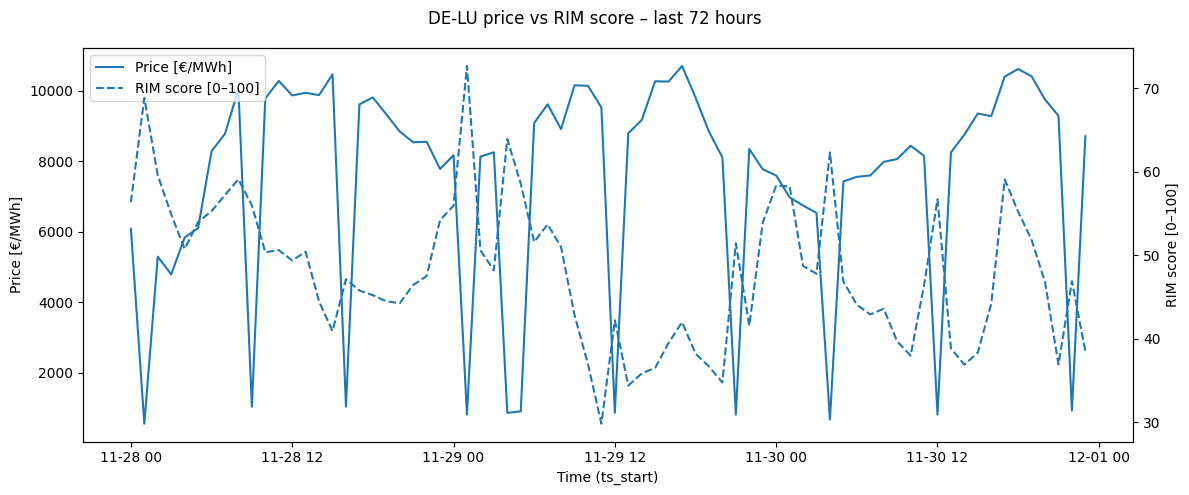


==================== CURRENT RISK SNAPSHOT ====================

Timestamp        : 2025-11-30T23:00:00  (zone DE-LU)
RIM score        : 38.5  | regime: REGIME_2_ATTENTION
Price now        : Price now: 8713.0 €/MWh.
Evaluator score  : 0.80

Key drivers (Analyst view):
  - RIM_PD: impact=MEDIUM | Dummy explanation – Gemini API key not set.
  - RIM_LD: impact=MEDIUM | Dummy explanation – Gemini API key not set.

Evaluator issues / corrections:
  * Issue      : Diagnostics do not clearly reference the current price.
    Suggestion : Add a diagnostic bullet with the current price level.

Short-term scenarios (Forecaster):

  Horizon       : 0-6h
    Price dir   : SIDEWAYS
    Vol outlook : MEDIUM
    Regime bias : oscillating within ATTENTION
    Summary     : Current regime REGIME_2_ATTENTION with score 38.5 suggests short-term conditions are medium-to-medium with limited visibility on direction in the very near term.
    Confidence  : 0.50

  Horizon       : 6-24h
    Price dir   : UNCE

In [ ]:
# STEP 14 – Notebook dashboard: price/RIM chart + textual risk panel


# --- 1) Build a small recent window for plotting (e.g. last 72 hours) ---

if "df_rim_clean" not in globals():
    raise RuntimeError("df_rim_clean missing. Run the data/RIM steps first.")

# Ensure index is sorted
df_rim_clean = df_rim_clean.sort_index()

latest_ts = df_rim_clean.index.max()
window_hours = 72  # last 3 days
start_ts = latest_ts - pd.Timedelta(hours=window_hours)

df_plot = df_rim_clean.loc[start_ts:latest_ts].copy()

if df_plot.empty:
    raise RuntimeError("Plot window is empty. Check that you have enough data.")

# --- 2) Plot price and RIM score on twin axes ---

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df_plot.index, df_plot["price"], label="Price [€/MWh]")
ax1.set_xlabel("Time (ts_start)")
ax1.set_ylabel("Price [€/MWh]")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
ax2.plot(df_plot.index, df_plot["RIM_SCORE_0_100"], linestyle="--", label="RIM score [0–100]")
ax2.set_ylabel("RIM score [0–100]")
ax2.tick_params(axis="y")

fig.suptitle("DE-LU price vs RIM score – last 72 hours")

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()


# --- 3) Pretty-print the current risk panel in a more human-friendly format ---

panel = risk_panel_latest  # from previous step

print("\n==================== CURRENT RISK SNAPSHOT ====================\n")
print(f"Timestamp        : {panel['timestamp']}  (zone {panel['zone']})")
print(f"RIM score        : {panel['rim']['score']:.1f}  | regime: {panel['rim']['regime']}")
print(f"Price now        : {panel['analyst']['diagnostics'][0]}")  # first diagnostic is price line
print(f"Evaluator score  : {panel['evaluation']['score']:.2f}")

# Drivers
print("\nKey drivers (Analyst view):")
for d in panel["analyst"]["drivers"]:
    print(f"  - {d['name']}: impact={d['impact']} | {d['explanation']}")

# Evaluation issues
if panel["evaluation"]["issues"]:
    print("\nEvaluator issues / corrections:")
    for iss, corr in zip(
        panel["evaluation"]["issues"], panel["evaluation"]["corrections"], strict=False
    ):
        print(f"  * Issue      : {iss}")
        print(f"    Suggestion : {corr}")

# Forecast horizons
print("\nShort-term scenarios (Forecaster):")
for h in panel["forecast"]["horizons"]:
    print(f"\n  Horizon       : {h['horizon']}")
    print(f"    Price dir   : {h['price_direction']}")
    print(f"    Vol outlook : {h['volatility_outlook']}")
    print(f"    Regime bias : {h['regime_bias']}")
    print(f"    Summary     : {h['scenario_summary']}")
    print(f"    Confidence  : {h['confidence']:.2f}")

print("\nGlobal forecast comment:")
print(panel["forecast"]["global_comment"])

print("\nModels used:")
print(f"  Analyst   : {panel['pipeline_meta']['analyst_model']}")
print(f"  Evaluator : {panel['pipeline_meta']['evaluator_model']}")
print(f"  Forecaster: {panel['pipeline_meta']['forecaster_model']}")

In [ ]:
import pandas as pd

res_csv_path = "de_res_actual.csv"

df_res_raw = pd.read_csv(res_csv_path, sep=";", engine="python")

print("=== RES RAW COLUMNS ===")
print(df_res_raw.columns.tolist())

print("\n=== RAW SHAPE ===")
print(df_res_raw.shape)

print("\n=== FIRST 10 ROWS ===")
print(df_res_raw.head(10))

=== RES RAW COLUMNS ===
['Start date', 'End date', 'Biomass [MWh] Original resolutions', 'Hydropower [MWh] Original resolutions', 'Wind offshore [MWh] Original resolutions', 'Wind onshore [MWh] Original resolutions', 'Photovoltaics [MWh] Original resolutions', 'Other renewable [MWh] Original resolutions', 'Nuclear [MWh] Original resolutions', 'Lignite [MWh] Original resolutions', 'Hard coal [MWh] Original resolutions', 'Fossil gas [MWh] Original resolutions', 'Hydro pumped storage [MWh] Original resolutions', 'Other conventional [MWh] Original resolutions']

=== RAW SHAPE ===
(70272, 14)

=== FIRST 10 ROWS ===
              Start date               End date Biomass [MWh] Original resolutions  \
0  Nov 30, 2023 12:00 AM  Nov 30, 2023 12:15 AM                           1,033.75   
1  Nov 30, 2023 12:15 AM  Nov 30, 2023 12:30 AM                           1,036.50   
2  Nov 30, 2023 12:30 AM  Nov 30, 2023 12:45 AM                           1,037.00   
3  Nov 30, 2023 12:45 AM   Nov 30, 202

In [ ]:
# ======================================================
# STEP RES – Load and aggregate RES actual generation
# ======================================================

# 1) Load raw RES CSV (robust reader)
# ------------------------------------------------------
df_res_raw = pd.read_csv(RES_CSV, sep=";", engine="python", on_bad_lines="skip", encoding="utf-8")

print("=== RES RAW COLUMNS ===")
print(df_res_raw.columns.tolist())
print("\n=== RAW SHAPE ===")
print(df_res_raw.shape)

# Make a working copy
df_res = df_res_raw.copy()


# 2) Parse timestamps
# ------------------------------------------------------
df_res["ts_start"] = pd.to_datetime(df_res["Start date"], errors="coerce")
df_res["ts_end"] = pd.to_datetime(df_res["End date"], errors="coerce")

# Drop rows with bad timestamps
df_res = df_res.dropna(subset=["ts_start"])


# 3) Identify RES columns
# ------------------------------------------------------
res_columns = [
    "Biomass [MWh] Original resolutions",
    "Hydropower [MWh] Original resolutions",
    "Wind offshore [MWh] Original resolutions",
    "Wind onshore [MWh] Original resolutions",
    "Photovoltaics [MWh] Original resolutions",
    "Other renewable [MWh] Original resolutions",
]


# 4) Clean numeric strings → float
# ------------------------------------------------------
for col in res_columns:
    s = df_res[col].astype(str).str.strip()
    s = s.replace({"-": "0", "": "0"})
    df_res[col] = pd.to_numeric(s.str.replace(",", "", regex=False), errors="coerce").fillna(0.0)


# 5) Compute total RES MWh per 15-min
# ------------------------------------------------------
df_res["RES_total_MWh"] = df_res[res_columns].sum(axis=1)

# Keep minimal required columns
df_res = df_res[["ts_start", "RES_total_MWh"] + res_columns]


# 6) Sort and set index
# ------------------------------------------------------
df_res = df_res.sort_values("ts_start")
df_res = df_res.set_index("ts_start")


# 7) Resample 15-minute → hourly (sum over 4 intervals)
# ------------------------------------------------------
df_res_hourly = df_res.resample("1H").sum()

print("\n=== RES HOURLY SHAPE ===")
print(df_res_hourly.shape)

print("\n=== HOURLY SAMPLE (RES_total_MWh) ===")
print(df_res_hourly[["RES_total_MWh"]].head(10))

=== RES RAW COLUMNS ===
['Start date', 'End date', 'Biomass [MWh] Original resolutions', 'Hydropower [MWh] Original resolutions', 'Wind offshore [MWh] Original resolutions', 'Wind onshore [MWh] Original resolutions', 'Photovoltaics [MWh] Original resolutions', 'Other renewable [MWh] Original resolutions', 'Nuclear [MWh] Original resolutions', 'Lignite [MWh] Original resolutions', 'Hard coal [MWh] Original resolutions', 'Fossil gas [MWh] Original resolutions', 'Hydro pumped storage [MWh] Original resolutions', 'Other conventional [MWh] Original resolutions']

=== RAW SHAPE ===
(70272, 14)


/tmp/ipython-input-1425412297.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_res["ts_start"] = pd.to_datetime(df_res["Start date"], errors="coerce")
/tmp/ipython-input-1425412297.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_res["ts_end"]   = pd.to_datetime(df_res["End date"],   errors="coerce")



=== RES HOURLY SHAPE ===
(17568, 7)

=== HOURLY SAMPLE (RES_total_MWh) ===
                     RES_total_MWh
ts_start                          
2023-11-30 00:00:00       11847.50
2023-11-30 01:00:00       10812.00
2023-11-30 02:00:00       10018.00
2023-11-30 03:00:00        9180.00
2023-11-30 04:00:00        8938.25
2023-11-30 05:00:00        8790.75
2023-11-30 06:00:00        9046.00
2023-11-30 07:00:00        9552.75
2023-11-30 08:00:00       10043.25
2023-11-30 09:00:00       10966.75


/tmp/ipython-input-1425412297.py:72: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_res_hourly = df_res.resample("1H").sum()


In [ ]:
# STEP 16 – Clean and normalize RES actuals (15-min → hourly) – FINAL

import numpy as np
import pandas as pd

# Start from original raw DF
df_res = df_res_raw.copy()

# -----------------------------
# 1. Fix timestamps
# -----------------------------
df_res["ts_start"] = pd.to_datetime(df_res["Start date"], errors="coerce")
df_res["ts_end"] = pd.to_datetime(df_res["End date"], errors="coerce")

# Drop rows missing timestamps
df_res = df_res.dropna(subset=["ts_start", "ts_end"])

# Set index to ts_start and sort
df_res = df_res.set_index("ts_start").sort_index()

# -----------------------------
# 2. Identify RES columns (renewables only)
# -----------------------------
res_columns = [
    "Biomass [MWh] Original resolutions",
    "Hydropower [MWh] Original resolutions",
    "Wind offshore [MWh] Original resolutions",
    "Wind onshore [MWh] Original resolutions",
    "Photovoltaics [MWh] Original resolutions",
    "Other renewable [MWh] Original resolutions",
]

# -----------------------------
# 3. Clean numeric values in RES columns
#    - "-" -> NaN
#    - remove thousand separators
# -----------------------------
for col in res_columns:
    s = df_res[col].astype(str).str.strip()
    s = s.replace("-", np.nan)
    s = s.str.replace(",", "", regex=False)  # "1,033.75" -> "1033.75"
    df_res[col] = pd.to_numeric(s, errors="coerce")

# -----------------------------
# 4. Compute total RES generation per 15-min
# -----------------------------
df_res["RES_total_MWh"] = df_res[res_columns].sum(axis=1)

# -----------------------------
# 5. Build a numeric-only frame for resampling
# -----------------------------
numeric_for_resample = df_res[res_columns + ["RES_total_MWh"]].copy()

# Resample from 15-min to hourly: sum over 4 intervals
df_res_hourly = numeric_for_resample.resample("1h").sum()  # use "1h" not "1H"

# Drop any all-NaN rows (if exist)
df_res_hourly = df_res_hourly.dropna(how="all")

print("=== RES HOURLY SHAPE ===")
print(df_res_hourly.shape)

print("\n=== HOURLY SAMPLE (RES_total_MWh) ===")
print(df_res_hourly[["RES_total_MWh"]].head(10))

print("\n=== HOURLY SAMPLE (RES components) ===")
print(df_res_hourly[res_columns].head(5))

/tmp/ipython-input-3437490648.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_res["ts_start"] = pd.to_datetime(df_res["Start date"], errors="coerce")
/tmp/ipython-input-3437490648.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_res["ts_end"]   = pd.to_datetime(df_res["End date"], errors="coerce")


=== RES HOURLY SHAPE ===
(17568, 7)

=== HOURLY SAMPLE (RES_total_MWh) ===
                     RES_total_MWh
ts_start                          
2023-11-30 00:00:00       11847.50
2023-11-30 01:00:00       10812.00
2023-11-30 02:00:00       10018.00
2023-11-30 03:00:00        9180.00
2023-11-30 04:00:00        8938.25
2023-11-30 05:00:00        8790.75
2023-11-30 06:00:00        9046.00
2023-11-30 07:00:00        9552.75
2023-11-30 08:00:00       10043.25
2023-11-30 09:00:00       10966.75

=== HOURLY SAMPLE (RES components) ===
                     Biomass [MWh] Original resolutions  Hydropower [MWh] Original resolutions  \
ts_start                                                                                         
2023-11-30 00:00:00                             4142.75                                1874.25   
2023-11-30 01:00:00                             4121.00                                1882.75   
2023-11-30 02:00:00                             4095.25                  

In [ ]:
# STEP 17 – Add RIM_RES (renewable risk) and recompute RIM with 3 factors

import numpy as np
import pandas as pd

# Safety checks
if "df_rim_clean" not in globals():
    raise RuntimeError("df_rim_clean is not defined. Run your RIM PD/LD steps first.")

if "df_res_hourly" not in globals():
    raise RuntimeError("df_res_hourly is not defined. Run STEP 16 first.")


# -----------------------------
# 1. Prepare RES for join
# -----------------------------
# We only need total RES for now (we can add per-tech factors later)
df_res_for_join = df_res_hourly[["RES_total_MWh"]].copy()
df_res_for_join = df_res_for_join.rename(columns={"RES_total_MWh": "res_mwh"})

# Align index names for clarity
df_res_for_join.index.name = "ts_start"

# Join onto existing RIM table (which is indexed by ts_start)
df_rim_res = df_rim_clean.join(df_res_for_join, how="inner")

print("Joined RIM + RES shape:", df_rim_res.shape)
print(df_rim_res[["price", "load_mw", "res_mwh"]].head())


# -----------------------------
# 2. Helper: quantile-based 0–10 scaler (re-use / re-define)
# -----------------------------
def normalize_series_to_0_10(
    series: pd.Series, q_low: float = 0.10, q_high: float = 0.95
) -> pd.Series:
    """
    Map a series to a 0–10 scale using lower/upper quantiles.
    Values below q_low -> 0, above q_high -> 10, linear in between.
    """
    s = series.astype(float)
    lo = s.quantile(q_low)
    hi = s.quantile(q_high)
    if np.isclose(hi, lo):
        return pd.Series(0.0, index=s.index)
    scaled = 10.0 * (s - lo) / (hi - lo)
    return scaled.clip(lower=0.0, upper=10.0)


# -----------------------------
# 3. Build RES dynamics
# -----------------------------

# RES ramps (MWh per hour)
df_rim_res["res_ramp_1h"] = df_rim_res["res_mwh"].diff()
df_rim_res["res_ramp_3h"] = df_rim_res["res_mwh"].diff(3)

# RES z-score vs 24h rolling mean
roll_res_mean_24h = df_rim_res["res_mwh"].rolling(24).mean()
roll_res_std_24h = df_rim_res["res_mwh"].rolling(24).std()

df_rim_res["res_zscore_24h"] = (df_rim_res["res_mwh"] - roll_res_mean_24h) / roll_res_std_24h
df_rim_res["abs_res_zscore_24h"] = df_rim_res["res_zscore_24h"].abs()

# Normalize RES components to 0–10
df_rim_res["res_zscore_score"] = normalize_series_to_0_10(df_rim_res["abs_res_zscore_24h"])
df_rim_res["res_ramp_1h_score"] = normalize_series_to_0_10(df_rim_res["res_ramp_1h"].abs())
df_rim_res["res_ramp_3h_score"] = normalize_series_to_0_10(df_rim_res["res_ramp_3h"].abs())

# -----------------------------
# 4. RIM_RES factor (0–10)
# -----------------------------
# Weights: zscore (0.5), 1h ramp (0.3), 3h ramp (0.2)
df_rim_res["RIM_RES"] = (
    0.5 * df_rim_res["res_zscore_score"]
    + 0.3 * df_rim_res["res_ramp_1h_score"]
    + 0.2 * df_rim_res["res_ramp_3h_score"]
)


# -----------------------------
# 5. Rebuild global RIM with 3 factors (PD, LD, RES)
# -----------------------------

# First, keep original PD/LD factors (assumed present from earlier step)
# df_rim_clean already had: RIM_PD, RIM_LD, RIM_SCORE_0_100, RIM_REGIME
# Now we create a 3-factor version.

RIM_PD_WEIGHT = 0.5  # price dynamics
RIM_LD_WEIGHT = 0.25  # load dynamics
RIM_RES_WEIGHT = 0.25  # RES dynamics

df_rim_res["RIM_0_10_3F"] = (
    RIM_PD_WEIGHT * df_rim_res["RIM_PD"]
    + RIM_LD_WEIGHT * df_rim_res["RIM_LD"]
    + RIM_RES_WEIGHT * df_rim_res["RIM_RES"]
)

df_rim_res["RIM_SCORE_0_100_3F"] = df_rim_res["RIM_0_10_3F"] * 10.0


# -----------------------------
# 6. Map new score to regimes (5 levels, same thresholds)
# -----------------------------
def map_rim_to_regime(score: float) -> str:
    if score < 15:
        return "REGIME_0_CALM"
    elif score < 35:
        return "REGIME_1_NORMAL"
    elif score < 55:
        return "REGIME_2_ATTENTION"
    elif score < 75:
        return "REGIME_3_STRESSED"
    else:
        return "REGIME_4_SEVERE"


df_rim_res["RIM_REGIME_3F"] = df_rim_res["RIM_SCORE_0_100_3F"].apply(map_rim_to_regime)

# Drop early rows with NaNs due to rolling RES stats
df_rim_res_clean = df_rim_res.dropna(subset=["RIM_PD", "RIM_LD", "RIM_RES", "RIM_SCORE_0_100_3F"])

print("\n=== RIM with RES (3-factor) ===")
print("df_rim_res_clean shape:", df_rim_res_clean.shape)
print(
    df_rim_res_clean[
        [
            "price",
            "load_mw",
            "res_mwh",
            "RIM_PD",
            "RIM_LD",
            "RIM_RES",
            "RIM_SCORE_0_100_3F",
            "RIM_REGIME_3F",
        ]
    ].head()
)

print("\nNew regime distribution (3-factor RIM):")
print(df_rim_res_clean["RIM_REGIME_3F"].value_counts())

Joined RIM + RES shape: (145, 28)
                     price   load_mw   res_mwh
ts_start                                      
2025-11-23 23:00:00   7126  52.11571  33903.85
2025-11-24 00:00:00   7246  49.63955  32529.93
2025-11-24 01:00:00   7006  47.96621  30855.37
2025-11-24 02:00:00   7226  47.36992  29847.62
2025-11-24 03:00:00   7328  47.48993  29347.11

=== RIM with RES (3-factor) ===
df_rim_res_clean shape: (122, 39)
                     price   load_mw   res_mwh    RIM_PD    RIM_LD   RIM_RES  RIM_SCORE_0_100_3F       RIM_REGIME_3F
ts_start                                                                                                            
2025-11-24 22:00:00  12304  59.22301  15088.84  0.248718  4.824923  5.857495           27.949635     REGIME_1_NORMAL
2025-11-24 23:00:00  10541  55.35322  14297.93  0.378966  6.323952  5.502893           31.461941     REGIME_1_NORMAL
2025-11-25 00:00:00   1009  52.61963  13517.88  3.388121  6.323304  5.409314           46.272153  REGI

In [ ]:
# STEP 18 – Build 3-factor RIM context for LLM agents

import json


def build_rim_context_3f(df_rim_res_clean):
    """
    Extract the latest hour and package all relevant RIM information
    (PD, LD, RES factors, scores, snapshots) for Analyst, Evaluator,
    and Forecaster LLMs.
    """
    latest = df_rim_res_clean.iloc[-1]

    context = {
        "ts": latest.name.isoformat(),
        "zone": "DE-LU",
        "rim": {
            "score_3f": float(latest["RIM_SCORE_0_100_3F"]),
            "regime_3f": latest["RIM_REGIME_3F"],
            "RIM_PD": float(latest["RIM_PD"]),
            "RIM_LD": float(latest["RIM_LD"]),
            "RIM_RES": float(latest["RIM_RES"]),
        },
        "price_snapshot": {
            "price_now": float(latest["price"]),
            "zscore_24h": float(latest["zscore_24h"]),
            "vol_24h": float(latest["vol_24h"]),
            "vol_72h": float(latest["vol_72h"]),
        },
        "load_snapshot": {
            "load_mw": float(latest["load_mw"]),
            "load_zscore_24h": float(latest["load_zscore_24h"]),
            "load_ramp_1h": float(latest["load_ramp_1h"]),
            "load_ramp_3h": float(latest["load_ramp_3h"]),
        },
        "res_snapshot": {
            "res_mwh": float(latest["res_mwh"]),
            "res_zscore_24h": float(latest["res_zscore_24h"]),
            "res_ramp_1h": float(latest["res_ramp_1h"]),
            "res_ramp_3h": float(latest["res_ramp_3h"]),
        },
    }

    return context


# Build context now
rim_context_3f = build_rim_context_3f(df_rim_res_clean)

print("=== NEW 3-FACTOR RIM CONTEXT ===")
print(json.dumps(rim_context_3f, indent=2))

=== NEW 3-FACTOR RIM CONTEXT ===
{
  "ts": "2025-11-30T23:00:00",
  "zone": "DE-LU",
  "rim": {
    "score_3f": 41.750130675743776,
    "regime_3f": "REGIME_2_ATTENTION",
    "RIM_PD": 4.575653444971926,
    "RIM_LD": 2.765647249709602,
    "RIM_RES": 4.783098130644056
  },
  "price_snapshot": {
    "price_now": 8713.0,
    "zscore_24h": 0.4245441022340288,
    "vol_24h": 5.789248196212124,
    "vol_72h": 10.415270505301878
  },
  "load_snapshot": {
    "load_mw": 49.4301,
    "load_zscore_24h": -0.2579927638020048,
    "load_ramp_1h": -2.668219999999998,
    "load_ramp_3h": -6.050229999999999
  },
  "res_snapshot": {
    "res_mwh": 28745.83,
    "res_zscore_24h": -1.339156258061006,
    "res_ramp_1h": -799.8400000000001,
    "res_ramp_3h": -2869.7700000000004
  }
}


In [ ]:
# STEP 19 – 3-factor Analyst LLM (PD, LD, RES)

ANALYST_SYSTEM_PROMPT_3F = """
You are the RISK ANALYST for the DE-LU (Germany/Luxembourg) power market.

You receive a quantitative 3-factor Risk Intelligence Model (RIM) summary
for the latest hour, with:
- RIM_PD : price dynamics factor (0–10)
- RIM_LD : load dynamics factor  (0–10)
- RIM_RES: renewable dynamics    (0–10)
- RIM_SCORE_0_100_3F: global risk score (0–100) from these factors
- RIM_REGIME_3F: qualitative regime label (CALM, NORMAL, ATTENTION, STRESSED, SEVERE)

You ALSO receive:
- price snapshot (level, z-score, 24h vol, 72h vol)
- load snapshot (level, z-score, 1h and 3h ramps)
- RES snapshot  (total RES MWh, z-score vs 24h, 1h and 3h ramps)

Your job:
1) Interpret the 3-factor RIM state.
2) Identify which factors (PD, LD, RES) are driving the risk.
3) Provide a short, risk-focused briefing. NO trading advice. NO P&L suggestions.
4) Explicitly mention RES behaviour if RIM_RES is non-trivial (>= 3).
5) Clearly distinguish between price-driven stress, load-driven stress, and RES-driven stress.

You MUST return valid JSON ONLY, with this schema:

{
  "summary": "1–3 sentence high-level risk overview, mentioning the regime and main drivers.",
  "diagnostics": [
    "bullet-style, factual diagnostics about price, load, RES, and volatility",
    "... more bullets"
  ],
  "drivers": [
    {
      "name": "RIM_PD | RIM_LD | RIM_RES",
      "impact": "LOW | MEDIUM | HIGH",
      "explanation": "1–2 sentence explanation"
    }
  ],
  "risk_notes": [
    "short statements about operational risk implications (monitoring, attention, but no trade advice)"
  ],
  "confidence": 0.0-1.0,
  "model_used": "..."
}
"""


def call_analyst_llm(rim_context: dict, model_name: str = "gemini-1.5-flash") -> dict:
    """
    3-factor Analyst LLM:
    - Consumes rim_context_3f
    - Produces structured risk briefing based on PD, LD, RES.

    Falls back to deterministic dummy output if GEMINI_API_KEY is not set.
    """

    rim = rim_context["rim"]
    price = rim_context["price_snapshot"]
    load = rim_context["load_snapshot"]
    res = rim_context["res_snapshot"]

    score = rim["score_3f"]
    regime = rim["regime_3f"]
    pd = rim["RIM_PD"]
    ld = rim["RIM_LD"]
    rs = rim["RIM_RES"]

    # ---------- Dummy path (no API key) ----------
    if not GEMINI_API_KEY:
        # Determine rough impact labels
        def impact_label(x: float) -> str:
            if x < 2.0:
                return "LOW"
            elif x < 5.0:
                return "MEDIUM"
            else:
                return "HIGH"

        drivers = [
            {
                "name": "RIM_PD",
                "impact": impact_label(pd),
                "explanation": "Price dynamics contribution based on realized volatility and price z-scores. Dummy explanation – no LLM key configured.",
            },
            {
                "name": "RIM_LD",
                "impact": impact_label(ld),
                "explanation": "Load dynamics contribution from load ramps and deviations vs rolling mean. Dummy explanation – no LLM key configured.",
            },
            {
                "name": "RIM_RES",
                "impact": impact_label(rs),
                "explanation": "Renewable dynamics contribution from RES level, ramps, and 24h z-scores. Dummy explanation – no LLM key configured.",
            },
        ]

        diagnostics = [
            f"Regime (3-factor): {regime} with score {score:.1f}.",
            f"Price now: {price['price_now']:.1f} €/MWh; 24h z-score: {price['zscore_24h']:.2f}; vol_24h: {price['vol_24h']:.2f}, vol_72h: {price['vol_72h']:.2f}.",
            f"Load: {load['load_mw']:.2f} GW (approx); load z-score: {load['load_zscore_24h']:.2f}; ramps 1h/3h: {load['load_ramp_1h']:.2f}, {load['load_ramp_3h']:.2f}.",
            f"RES total: {res['res_mwh']:.2f} MWh; RES z-score: {res['res_zscore_24h']:.2f}; ramps 1h/3h: {res['res_ramp_1h']:.2f}, {res['res_ramp_3h']:.2f}.",
        ]

        risk_notes = [
            "Dummy analyst: RIM_PD, RIM_LD, and RIM_RES indicate a multi-factor ATTENTION regime; no real LLM analysis because no API key is configured."
        ]

        return {
            "summary": (
                f"3-factor risk regime is {regime} with score {score:.1f}, "
                "driven by a mix of price, load, and renewable dynamics."
            ),
            "diagnostics": diagnostics,
            "drivers": drivers,
            "risk_notes": risk_notes,
            "confidence": 0.0,
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    prompt = f"""
{ANALYST_SYSTEM_PROMPT_3F}

CURRENT RIM CONTEXT (3-factor, JSON):
{json.dumps(rim_context, indent=2)}
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "summary": "Analyst LLM did not return valid JSON; raw text preserved.",
            "raw_text": raw,
            "diagnostics": [],
            "drivers": [],
            "risk_notes": [],
            "confidence": 0.0,
            "model_used": model_name,
        }
    return out


# --- TEST: run Analyst on new 3-factor context ---

analyst_output_3f = call_analyst_llm(rim_context_3f)
print("3-factor Analyst output:")
print(json.dumps(analyst_output_3f, indent=2))

3-factor Analyst output:
{
  "summary": "3-factor risk regime is REGIME_2_ATTENTION with score 41.8, driven by a mix of price, load, and renewable dynamics.",
  "diagnostics": [
    "Regime (3-factor): REGIME_2_ATTENTION with score 41.8.",
    "Price now: 8713.0 \u20ac/MWh; 24h z-score: 0.42; vol_24h: 5.79, vol_72h: 10.42.",
    "Load: 49.43 GW (approx); load z-score: -0.26; ramps 1h/3h: -2.67, -6.05.",
    "RES total: 28745.83 MWh; RES z-score: -1.34; ramps 1h/3h: -799.84, -2869.77."
  ],
  "drivers": [
    {
      "name": "RIM_PD",
      "impact": "MEDIUM",
      "explanation": "Price dynamics contribution based on realized volatility and price z-scores. Dummy explanation \u2013 no LLM key configured."
    },
    {
      "name": "RIM_LD",
      "impact": "MEDIUM",
      "explanation": "Load dynamics contribution from load ramps and deviations vs rolling mean. Dummy explanation \u2013 no LLM key configured."
    },
    {
      "name": "RIM_RES",
      "impact": "MEDIUM",
      "explan

In [ ]:
# STEP 20 – 3-factor Forecaster LLM (PD, LD, RES)

FORECASTER_SYSTEM_PROMPT_3F = """
You are the RISK SCENARIO FORECASTER for the DE-LU (Germany/Luxembourg) power market.

You receive a 3-factor Risk Intelligence Model (RIM) snapshot for the current hour, including:
- RIM_PD  : price dynamics factor      (0–10)
- RIM_LD  : load dynamics factor       (0–10)
- RIM_RES : renewable dynamics factor  (0–10)
- RIM_SCORE_0_100_3F: global risk score (0–100)
- RIM_REGIME_3F: qualitative regime label (CALM, NORMAL, ATTENTION, STRESSED, SEVERE)

You ALSO receive:
- price snapshot (level, z-score, 24h/72h volatility),
- load snapshot (level, z-score, 1h and 3h ramps),
- RES snapshot  (total MWh, 24h z-score, 1h and 3h ramps).

Your job:
1) Provide SHORT-TERM qualitative scenario outlooks for:
   - 0–6 hours ahead,
   - 6–24 hours ahead.
2) Focus on:
   - direction of risk (UP, DOWN, SIDEWAYS, UNCERTAIN),
   - expected volatility (LOW, MEDIUM, HIGH),
   - regime bias (towards CALM, ATTENTION, STRESSED, SEVERE),
   - how PD, LD, and RES might evolve or interact.
3) Highlight RES-driven risks explicitly if RIM_RES is notable (>= 3):
   - RES undershoot / shortfall,
   - RES overshoot,
   - sharp RES ramps,
   - impact on system balance.
4) NO trading advice, NO P&L, NO strategy recommendations.

You MUST return valid JSON ONLY, with this schema:

{
  "horizons": [
    {
      "horizon": "0-6h",
      "price_direction": "UP | DOWN | SIDEWAYS | UNCERTAIN",
      "volatility_outlook": "LOW | MEDIUM | HIGH",
      "regime_bias": "one-line text about likely regime drift",
      "scenario_summary": "2–4 sentence description of likely evolution, mentioning PD/LD/RES balance",
      "key_risks": [
        "bullet-style short risk statements"
      ],
      "confidence": 0.0-1.0
    },
    {
      "horizon": "6-24h",
      "price_direction": "...",
      "volatility_outlook": "...",
      "regime_bias": "...",
      "scenario_summary": "...",
      "key_risks": ["..."],
      "confidence": 0.0-1.0
    }
  ],
  "global_comment": "1–3 sentence wrap-up about short-term regime and risk evolution.",
  "model_used": "..."
}
"""


def call_forecaster_llm(rim_context: dict, model_name: str = "gemini-1.5-flash") -> dict:
    """
    3-factor Forecaster:
    - Consumes rim_context_3f
    - Produces short-horizon scenario outlooks based on PD, LD, RES.

    Falls back to a deterministic dummy output if GEMINI_API_KEY is not set.
    """

    rim = rim_context["rim"]
    price = rim_context["price_snapshot"]
    load = rim_context["load_snapshot"]
    res = rim_context["res_snapshot"]

    score = rim["score_3f"]
    regime = rim["regime_3f"]
    pd = rim["RIM_PD"]
    ld = rim["RIM_LD"]
    rs = rim["RIM_RES"]

    # ---------- Dummy path (no API key) ----------
    if not GEMINI_API_KEY:
        # Simple rule-based mapping for dummy mode
        if score < 25:
            vol_level = "LOW"
            dir_short = "SIDEWAYS"
            dir_mid = "SIDEWAYS"
        elif score < 45:
            vol_level = "MEDIUM"
            dir_short = "SIDEWAYS"
            dir_mid = "UNCERTAIN"
        else:
            vol_level = "HIGH"
            dir_short = "UNCERTAIN"
            dir_mid = "UNCERTAIN"

        res_risk_flag = rs >= 3.0

        key_risks_0_6 = [
            "Localised price swings from intraday rebalancing.",
            "Short-term sensitivity to load ramps.",
        ]
        key_risks_6_24 = [
            "Accumulation of intraday imbalances.",
            "Potential shift in residual load if RES output deviates from expectations.",
        ]

        if res_risk_flag:
            key_risks_0_6.append(
                "RES ramps and z-score deviations may amplify short-term imbalance risk."
            )
            key_risks_6_24.append(
                "Sustained RES undershoot/overshoot could shift the regime towards STRESSED conditions."
            )

        horizons = [
            {
                "horizon": "0-6h",
                "price_direction": dir_short,
                "volatility_outlook": vol_level,
                "regime_bias": f"staying near {regime} or mild drift depending on PD/RES interaction",
                "scenario_summary": (
                    f"Current 3-factor regime {regime} with score {score:.1f} suggests "
                    f"{vol_level.lower()} short-term volatility. Price dynamics (RIM_PD={pd:.1f}), "
                    f"load behaviour (RIM_LD={ld:.1f}), and renewable dynamics (RIM_RES={rs:.1f}) "
                    "combine to keep conditions in an ATTENTION-like band unless a strong shock occurs."
                ),
                "key_risks": key_risks_0_6,
                "confidence": 0.5,
            },
            {
                "horizon": "6-24h",
                "price_direction": dir_mid,
                "volatility_outlook": vol_level,
                "regime_bias": f"oscillating within {regime} with potential drift if RES or load patterns change materially",
                "scenario_summary": (
                    f"Over the next 6–24 hours, the 3-factor regime may either stabilise around {regime} "
                    "or move one notch higher if persistent volatility in price or RES ramps materialises. "
                    "Structural changes in load and RES balance will be the main drivers of any regime transition."
                ),
                "key_risks": key_risks_6_24,
                "confidence": 0.5,
            },
        ]

        global_comment = (
            "Dummy forecast: qualitative outlook derived from the 3-factor RIM score and components "
            "(PD, LD, RES); no real LLM model used because no API key is configured."
        )

        return {
            "horizons": horizons,
            "global_comment": global_comment,
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    prompt = f"""
{FORECASTER_SYSTEM_PROMPT_3F}

CURRENT RIM CONTEXT (3-factor, JSON):
{json.dumps(rim_context, indent=2)}
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "horizons": [],
            "global_comment": "Forecaster LLM did not return valid JSON; raw text preserved.",
            "raw_text": raw,
            "model_used": model_name,
        }

    return out


# --- TEST: run 3-factor Forecaster on current context ---

forecaster_output_3f = call_forecaster_llm(rim_context_3f)
print("3-factor Forecaster output:")
print(json.dumps(forecaster_output_3f, indent=2))

3-factor Forecaster output:
{
  "horizons": [
    {
      "horizon": "0-6h",
      "price_direction": "SIDEWAYS",
      "volatility_outlook": "MEDIUM",
      "regime_bias": "staying near REGIME_2_ATTENTION or mild drift depending on PD/RES interaction",
      "scenario_summary": "Current 3-factor regime REGIME_2_ATTENTION with score 41.8 suggests medium short-term volatility. Price dynamics (RIM_PD=4.6), load behaviour (RIM_LD=2.8), and renewable dynamics (RIM_RES=4.8) combine to keep conditions in an ATTENTION-like band unless a strong shock occurs.",
      "key_risks": [
        "Localised price swings from intraday rebalancing.",
        "Short-term sensitivity to load ramps.",
        "RES ramps and z-score deviations may amplify short-term imbalance risk."
      ],
      "confidence": 0.5
    },
    {
      "horizon": "6-24h",
      "price_direction": "UNCERTAIN",
      "volatility_outlook": "MEDIUM",
      "regime_bias": "oscillating within REGIME_2_ATTENTION with potential drift

In [ ]:
# STEP 21 – 3-factor Evaluator + unified risk intelligence panel

import json

EVALUATOR_SYSTEM_PROMPT_3F = """
You are the RISK EVALUATOR for a 3-factor RIM-based AI agent in the DE-LU power market.

You receive:
- A 3-factor RIM context (PD, LD, RES, global score, regime),
- The ANALYST output (risk summary and diagnostics),
- The FORECASTER output (short-term scenarios).

Your job:
1) Check whether the ANALYST summary and diagnostics are:
   - consistent with the RIM score and regime,
   - mentioning key factors (PD, LD, RES) when they are significant.
2) Check whether the FORECASTER scenarios:
   - align broadly with the current regime and RIM score,
   - properly consider RES-driven risk if RIM_RES is notable.
3) Provide:
   - a numeric evaluation score [0.0–1.0],
   - a list of issues,
   - a list of suggested corrections.
4) NO trading advice, NO strategy suggestions.

You MUST output valid JSON ONLY, with schema:

{
  "score": 0.0-1.0,
  "issues": ["..."],
  "corrections": ["..."],
  "model_used": "..."
}
"""


def call_evaluator_llm_3f(
    rim_context: dict,
    analyst_output: dict,
    forecaster_output: dict,
    model_name: str = "gemini-1.5-flash",
) -> dict:
    """
    3-factor Evaluator:
    - Consumes RIM context, Analyst output, Forecaster output.
    - Returns a structured evaluation.
    - Dummy rule-based implementation when no GEMINI_API_KEY is set.
    """

    rim = rim_context["rim"]
    score = rim["score_3f"]
    regime = rim["regime_3f"]
    pd = rim["RIM_PD"]
    ld = rim["RIM_LD"]
    rs = rim["RIM_RES"]

    analyst_diag = analyst_output.get("diagnostics", [])
    analyst_summary = analyst_output.get("summary", "")
    fore_horizons = forecaster_output.get("horizons", [])

    # ---------- Dummy path (no API key) ----------
    if not GEMINI_API_KEY:
        issues = []
        corrections = []

        # 1) Check if RES is mentioned when RIM_RES is significant
        res_significant = rs >= 3.0
        analyst_text = analyst_summary + " " + " ".join(analyst_diag)
        fore_text = json.dumps(fore_horizons)

        if res_significant:
            if "RES" not in analyst_text and "renewable" not in analyst_text.lower():
                issues.append(
                    "Analyst explanation does not explicitly reference RES despite RIM_RES being significant."
                )
                corrections.append(
                    "Add at least one diagnostic line that explicitly describes RES level, ramps, or z-score."
                )

            if "RES" not in fore_text and "renewable" not in fore_text.lower():
                issues.append(
                    "Forecaster scenarios do not explicitly reference RES-driven risk despite RIM_RES being significant."
                )
                corrections.append(
                    "In each horizon, reference RES dynamics as a potential amplifier of volatility or imbalance risk."
                )

        # 2) Rough consistency check between regime and score
        if regime == "REGIME_0_CALM" and score > 25:
            issues.append("Regime label CALM seems inconsistent with a score above 25.")
            corrections.append("Align CALM regime usage with scores clearly below 25.")
        if regime == "REGIME_3_STRESSED" and score < 35:
            issues.append("Regime label STRESSED seems inconsistent with a score below 35.")
            corrections.append("Reserve STRESSED for clearly elevated scores (e.g., > 50).")

        # 3) If no issues found, still give a non-perfect score to indicate dummy eval
        if not issues:
            eval_score = 0.85
        else:
            # Simple penalty per issue
            eval_score = max(0.4, 0.9 - 0.1 * len(issues))

        if not corrections:
            corrections.append(
                "No major structural problems detected in dummy evaluator; fine-tune wording and factor emphasis with a real LLM."
            )

        return {
            "score": float(eval_score),
            "issues": issues,
            "corrections": corrections,
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    payload = {
        "rim_context": rim_context,
        "analyst_output": analyst_output,
        "forecaster_output": forecaster_output,
    }

    prompt = f"""
{EVALUATOR_SYSTEM_PROMPT_3F}

CURRENT AGENT STATE (JSON):
{json.dumps(payload, indent=2)}
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "score": 0.0,
            "issues": ["Evaluator LLM did not return valid JSON; raw text preserved."],
            "corrections": [],
            "raw_text": raw,
            "model_used": model_name,
        }
    return out


# --------------------------
# Unified 3-factor panel
# --------------------------


def run_risk_intel_panel_3f(df_rim_res_clean):
    """
    Build a full 3-factor risk intelligence panel for the latest hour:
    - RIM context (PD, LD, RES)
    - Analyst LLM (3F)
    - Forecaster LLM (3F)
    - Evaluator LLM (3F)
    Returns a structured dict and pretty-prints a human-readable summary.
    """

    # 1) Build context
    ctx = build_rim_context_3f(df_rim_res_clean)

    # 2) Run agents
    analyst = call_analyst_llm(ctx)
    forecaster = call_forecaster_llm(ctx)
    evaluator = call_evaluator_llm_3f(ctx, analyst, forecaster)

    panel = {
        "timestamp": ctx["ts"],
        "zone": ctx["zone"],
        "rim": ctx["rim"],
        "price_snapshot": ctx["price_snapshot"],
        "load_snapshot": ctx["load_snapshot"],
        "res_snapshot": ctx["res_snapshot"],
        "analyst": analyst,
        "forecast": forecaster,
        "evaluation": evaluator,
        "pipeline_meta": {
            "analyst_model": analyst.get("model_used", "unknown"),
            "forecaster_model": forecaster.get("model_used", "unknown"),
            "evaluator_model": evaluator.get("model_used", "unknown"),
        },
    }

    # Pretty print
    print("=== 3-FACTOR RISK INTELLIGENCE PANEL ===\n")
    print(f"Timestamp        : {panel['timestamp']}  (zone {panel['zone']})")
    print(
        f"RIM score (3F)   : {panel['rim']['score_3f']:.1f} | regime: {panel['rim']['regime_3f']}"
    )

    ps = panel["price_snapshot"]
    ls = panel["load_snapshot"]
    rs = panel["res_snapshot"]

    print(
        f"Price now        : {ps['price_now']:.1f} €/MWh (z24h={ps['zscore_24h']:.2f}, vol24h={ps['vol_24h']:.2f}, vol72h={ps['vol_72h']:.2f})"
    )
    print(
        f"Load now         : {ls['load_mw']:.2f} GW (z24h={ls['load_zscore_24h']:.2f}, ramps 1h/3h={ls['load_ramp_1h']:.2f}/{ls['load_ramp_3h']:.2f})"
    )
    print(
        f"RES now          : {rs['res_mwh']:.2f} MWh (z24h={rs['res_zscore_24h']:.2f}, ramps 1h/3h={rs['res_ramp_1h']:.2f}/{rs['res_ramp_3h']:.2f})"
    )

    print("\nAnalyst summary:")
    print(f"  {analyst.get('summary', '')}")
    print("\nAnalyst diagnostics:")
    for d in analyst.get("diagnostics", []):
        print(f"  - {d}")

    print("\nKey drivers (Analyst view):")
    for drv in analyst.get("drivers", []):
        print(f"  - {drv.get('name')}: impact={drv.get('impact')} | {drv.get('explanation')}")

    print("\nRisk notes:")
    for rn in analyst.get("risk_notes", []):
        print(f"  * {rn}")

    print("\nForecaster horizons:")
    for h in forecaster.get("horizons", []):
        print(f"\n  Horizon       : {h.get('horizon')}")
        print(f"    Price dir   : {h.get('price_direction')}")
        print(f"    Vol outlook : {h.get('volatility_outlook')}")
        print(f"    Regime bias : {h.get('regime_bias')}")
        print(f"    Summary     : {h.get('scenario_summary')}")
        print(f"    Confidence  : {h.get('confidence'):.2f}")
        for kr in h.get("key_risks", []):
            print(f"      - {kr}")

    print("\nEvaluator:")
    print(f"  Score     : {evaluator.get('score'):.2f}")
    for issue in evaluator.get("issues", []):
        print(f"  Issue     : {issue}")
    for corr in evaluator.get("corrections", []):
        print(f"  Suggestion: {corr}")

    print("\nModels used:")
    print(f"  Analyst   : {panel['pipeline_meta']['analyst_model']}")
    print(f"  Forecaster: {panel['pipeline_meta']['forecaster_model']}")
    print(f"  Evaluator : {panel['pipeline_meta']['evaluator_model']}")

    return panel


# --- TEST: run the full 3-factor panel on latest hour ---

panel_3f = run_risk_intel_panel_3f(df_rim_res_clean)

=== 3-FACTOR RISK INTELLIGENCE PANEL ===

Timestamp        : 2025-11-30T23:00:00  (zone DE-LU)
RIM score (3F)   : 41.8 | regime: REGIME_2_ATTENTION
Price now        : 8713.0 €/MWh (z24h=0.42, vol24h=5.79, vol72h=10.42)
Load now         : 49.43 GW (z24h=-0.26, ramps 1h/3h=-2.67/-6.05)
RES now          : 28745.83 MWh (z24h=-1.34, ramps 1h/3h=-799.84/-2869.77)

Analyst summary:
  3-factor risk regime is REGIME_2_ATTENTION with score 41.8, driven by a mix of price, load, and renewable dynamics.

Analyst diagnostics:
  - Regime (3-factor): REGIME_2_ATTENTION with score 41.8.
  - Price now: 8713.0 €/MWh; 24h z-score: 0.42; vol_24h: 5.79, vol_72h: 10.42.
  - Load: 49.43 GW (approx); load z-score: -0.26; ramps 1h/3h: -2.67, -6.05.
  - RES total: 28745.83 MWh; RES z-score: -1.34; ramps 1h/3h: -799.84, -2869.77.

Key drivers (Analyst view):
  - RIM_PD: impact=MEDIUM | Price dynamics contribution based on realized volatility and price z-scores. Dummy explanation – no LLM key configured.
  - RIM_L

In [ ]:
# STEP 22 – RIM history plot (3-factor) + daily briefing helper

import matplotlib.pyplot as plt


def plot_rim_history_3f(df_rim_res_clean, last_n_hours: int = 9999999999):
    """
    Plot the 3-factor RIM score over time for the last N hours,
    with colored bands per regime.
    """
    df = df_rim_res_clean.copy()

    # Limit to last N hours if requested
    if last_n_hours is not None and last_n_hours > 0:
        df = df.iloc[-last_n_hours:]

    ts = df.index
    scores = df["RIM_SCORE_0_100_3F"]

    # Basic plot
    plt.figure(figsize=(14, 5))
    plt.plot(ts, scores, label="RIM_SCORE_0_100_3F")

    # Regime bands
    plt.axhspan(0, 15, alpha=0.08, label="CALM")
    plt.axhspan(15, 35, alpha=0.08, label="NORMAL")
    plt.axhspan(35, 55, alpha=0.08, label="ATTENTION")
    plt.axhspan(55, 75, alpha=0.08, label="STRESSED")
    plt.axhspan(75, 100, alpha=0.08, label="SEVERE")

    plt.title("3-Factor RIM Score (PD, LD, RES) – History")
    plt.ylabel("RIM Score (0–100)")
    plt.xlabel("Time")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def run_daily_briefing_3f(df_rim_res_clean, timestamp=None):
    """
    Convenience wrapper:
    - If timestamp is None: use latest hour.
    - If timestamp is provided (string or datetime), select the closest <= timestamp.
    - Run the 3F risk panel for that time slice.
    """
    df = df_rim_res_clean.sort_index()

    if timestamp is None:
        df_slice = df
    else:
        # Parse timestamp and slice up to that time
        ts = pd.to_datetime(timestamp)
        df_slice = df[df.index <= ts]
        if df_slice.empty:
            raise ValueError("No data available up to the requested timestamp.")

    return run_risk_intel_panel_3f(df_slice)

In [ ]:
# STEP 23 – Build RIM_IMB (imbalance risk) and 4-factor RIM

import numpy as np
import pandas as pd

# Safety check – we build on the 3F table with RES integrated
if "df_rim_res_clean" not in globals():
    raise RuntimeError("df_rim_res_clean is not defined. Run the 3-factor RIM steps first.")


# -----------------------------
# 1. Start from 3-factor table and copy
# -----------------------------
df_rim_4f = df_rim_res_clean.copy()

# We already have:
# - price
# - load_mw
# - res_mwh
# - RIM_PD, RIM_LD, RIM_RES
# - zscore_24h (price), load_zscore_24h, load_ramp_1h, load_ramp_3h
# - res_zscore_24h, res_ramp_1h, res_ramp_3h
# - RIM_SCORE_0_100_3F, RIM_REGIME_3F


# -----------------------------
# 2. Helper: quantile-based scaler (reuse, but safe to redefine)
# -----------------------------
def normalize_series_to_0_10(
    series: pd.Series, q_low: float = 0.10, q_high: float = 0.95
) -> pd.Series:
    """
    Map a series to a 0–10 scale using lower/upper quantiles.
    Values below q_low -> 0, above q_high -> 10, linear in between.
    """
    s = series.astype(float)
    lo = s.quantile(q_low)
    hi = s.quantile(q_high)
    if np.isclose(hi, lo):
        return pd.Series(0.0, index=s.index)
    scaled = 10.0 * (s - lo) / (hi - lo)
    return scaled.clip(lower=0.0, upper=10.0)


# -----------------------------
# 3. Residual load / imbalance proxies
# -----------------------------
# Approximate RES in GW-equivalent: 1,000 MWh per GW-hour
df_rim_4f["res_gw_equiv"] = df_rim_4f["res_mwh"] / 1000.0

# Residual load ≈ net demand not covered by RES
df_rim_4f["residual_load_gw"] = df_rim_4f["load_mw"] - df_rim_4f["res_gw_equiv"]

# Residual load ramps
df_rim_4f["residual_ramp_1h"] = df_rim_4f["residual_load_gw"].diff()
df_rim_4f["residual_ramp_3h"] = df_rim_4f["residual_load_gw"].diff(3)

# Residual z-score vs 24h rolling mean
roll_resid_mean_24h = df_rim_4f["residual_load_gw"].rolling(24).mean()
roll_resid_std_24h = df_rim_4f["residual_load_gw"].rolling(24).std()

df_rim_4f["residual_zscore_24h"] = (
    df_rim_4f["residual_load_gw"] - roll_resid_mean_24h
) / roll_resid_std_24h

# We care more about positive residual stress (demand > RES), so clip at 0
df_rim_4f["residual_zscore_pos"] = df_rim_4f["residual_zscore_24h"].clip(lower=0.0)

# Price abs z-score – imbalance that shows up in price is more critical
df_rim_4f["price_abs_zscore_24h"] = df_rim_4f["zscore_24h"].abs()


# -----------------------------
# 4. Scale imbalance components to 0–10
# -----------------------------
df_rim_4f["imb_residual_z_score"] = normalize_series_to_0_10(df_rim_4f["residual_zscore_pos"])
df_rim_4f["imb_residual_ramp_1h_score"] = normalize_series_to_0_10(
    df_rim_4f["residual_ramp_1h"].abs()
)
df_rim_4f["imb_residual_ramp_3h_score"] = normalize_series_to_0_10(
    df_rim_4f["residual_ramp_3h"].abs()
)
df_rim_4f["imb_price_abs_z_score"] = normalize_series_to_0_10(df_rim_4f["price_abs_zscore_24h"])


# -----------------------------
# 5. Aggregate into RIM_IMB (0–10)
# -----------------------------
# Intuition:
# - residual_zscore_pos: structural scarcity vs RES   (weight 0.4)
# - residual_ramp_1h: fast imbalance development      (weight 0.2)
# - residual_ramp_3h: sustained imbalance trend       (weight 0.2)
# - price_abs_zscore_24h: whether it shows in prices  (weight 0.2)
df_rim_4f["RIM_IMB"] = (
    0.4 * df_rim_4f["imb_residual_z_score"]
    + 0.2 * df_rim_4f["imb_residual_ramp_1h_score"]
    + 0.2 * df_rim_4f["imb_residual_ramp_3h_score"]
    + 0.2 * df_rim_4f["imb_price_abs_z_score"]
)


# -----------------------------
# 6. Build 4-factor RIM (PD, LD, RES, IMB)
# -----------------------------
# Adjust weights: you can tweak later; for now:
# PD  = 0.40 (price dynamics)
# LD  = 0.20 (load dynamics)
# RES = 0.20 (RES dynamics)
# IMB = 0.20 (imbalance proxy)
RIM_PD_WEIGHT = 0.40
RIM_LD_WEIGHT = 0.20
RIM_RES_WEIGHT = 0.20
RIM_IMB_WEIGHT = 0.20

df_rim_4f["RIM_0_10_4F"] = (
    RIM_PD_WEIGHT * df_rim_4f["RIM_PD"]
    + RIM_LD_WEIGHT * df_rim_4f["RIM_LD"]
    + RIM_RES_WEIGHT * df_rim_4f["RIM_RES"]
    + RIM_IMB_WEIGHT * df_rim_4f["RIM_IMB"]
)

df_rim_4f["RIM_SCORE_0_100_4F"] = df_rim_4f["RIM_0_10_4F"] * 10.0


# -----------------------------
# 7. Regime mapping (4F) – reuse thresholds
# -----------------------------
def map_rim_to_regime(score: float) -> str:
    if score < 15:
        return "REGIME_0_CALM"
    elif score < 35:
        return "REGIME_1_NORMAL"
    elif score < 55:
        return "REGIME_2_ATTENTION"
    elif score < 75:
        return "REGIME_3_STRESSED"
    else:
        return "REGIME_4_SEVERE"


df_rim_4f["RIM_REGIME_4F"] = df_rim_4f["RIM_SCORE_0_100_4F"].apply(map_rim_to_regime)

# Drop early rows where rolling residual stats are NaN
df_rim_4f_clean = df_rim_4f.dropna(
    subset=["RIM_PD", "RIM_LD", "RIM_RES", "RIM_IMB", "RIM_SCORE_0_100_4F"]
)

print("=== 4-FACTOR RIM TABLE (PD, LD, RES, IMB) ===")
print("df_rim_4f_clean shape:", df_rim_4f_clean.shape)
print(
    df_rim_4f_clean[
        [
            "price",
            "load_mw",
            "res_mwh",
            "residual_load_gw",
            "RIM_PD",
            "RIM_LD",
            "RIM_RES",
            "RIM_IMB",
            "RIM_SCORE_0_100_4F",
            "RIM_REGIME_4F",
        ]
    ].head()
)

print("\nNew regime distribution (4-factor RIM):")
print(df_rim_4f_clean["RIM_REGIME_4F"].value_counts())

=== 4-FACTOR RIM TABLE (PD, LD, RES, IMB) ===
df_rim_4f_clean shape: (99, 54)
                     price   load_mw   res_mwh  residual_load_gw    RIM_PD    RIM_LD   RIM_RES   RIM_IMB  \
ts_start                                                                                                   
2025-11-25 21:00:00  13502  62.77816  11951.80          50.82636  4.143873  3.534465  2.234459  2.168672   
2025-11-25 22:00:00  11916  59.20281  11373.80          47.82901  4.328987  5.228697  2.941752  2.557315   
2025-11-25 23:00:00  10204  55.32241  11285.47          44.03694  4.528354  6.916141  2.252540  3.083025   
2025-11-26 00:00:00   9285  52.29093  11618.73          40.67220  4.262481  7.309209  1.707877  3.102833   
2025-11-26 01:00:00   8995  50.67186  11719.03          38.95283  3.867032  6.532096  1.263647  2.285938   

                     RIM_SCORE_0_100_4F       RIM_REGIME_4F  
ts_start                                                     
2025-11-25 21:00:00           32.450685  

In [ ]:
# STEP 24 — Build 4-factor RIM context for LLM agents

import json

import numpy as np

if "df_rim_4f_clean" not in globals():
    raise RuntimeError("df_rim_4f_clean not computed. Run STEP 23 first.")

# Take the newest timestamp
latest_4f = df_rim_4f_clean.iloc[-1]

rim_context_4f = {
    "ts": latest_4f.name.isoformat(),
    "zone": "DE-LU",
    "rim_4f": {
        "score_4f": float(latest_4f["RIM_SCORE_0_100_4F"]),
        "regime_4f": latest_4f["RIM_REGIME_4F"],
        "RIM_PD": float(latest_4f["RIM_PD"]),
        "RIM_LD": float(latest_4f["RIM_LD"]),
        "RIM_RES": float(latest_4f["RIM_RES"]),
        "RIM_IMB": float(latest_4f["RIM_IMB"]),
    },
    "price_snapshot": {
        "price_now": float(latest_4f["price"]),
        "zscore_24h": float(latest_4f["zscore_24h"]),
        "vol_24h": float(latest_4f["vol_24h"]),
        "vol_72h": float(latest_4f["vol_72h"]),
    },
    "load_snapshot": {
        "load_mw": float(latest_4f["load_mw"]),
        "load_zscore_24h": float(latest_4f["load_zscore_24h"]),
        "load_ramp_1h": float(latest_4f["load_ramp_1h"]),
        "load_ramp_3h": float(latest_4f["load_ramp_3h"]),
    },
    "res_snapshot": {
        "res_mwh": float(latest_4f["res_mwh"]),
        "res_zscore_24h": float(latest_4f["res_zscore_24h"]),
        "res_ramp_1h": float(latest_4f["res_ramp_1h"]),
        "res_ramp_3h": float(latest_4f["res_ramp_3h"]),
    },
    "imbalance_snapshot": {
        "residual_load_gw": float(latest_4f["residual_load_gw"]),
        "residual_zscore_pos": float(latest_4f["residual_zscore_pos"]),
        "residual_ramp_1h": float(latest_4f["residual_ramp_1h"]),
        "residual_ramp_3h": float(latest_4f["residual_ramp_3h"]),
    },
}

print("=== 4-FACTOR CONTEXT BUILT ===")
print(json.dumps(rim_context_4f, indent=2))

=== 4-FACTOR CONTEXT BUILT ===
{
  "ts": "2025-11-30T23:00:00",
  "zone": "DE-LU",
  "rim_4f": {
    "score_4f": 37.285759516396396,
    "regime_4f": "REGIME_2_ATTENTION",
    "RIM_PD": 4.575653444971926,
    "RIM_LD": 2.765647249709602,
    "RIM_RES": 4.783098130644056,
    "RIM_IMB": 1.9428274879006882
  },
  "price_snapshot": {
    "price_now": 8713.0,
    "zscore_24h": 0.4245441022340288,
    "vol_24h": 5.789248196212124,
    "vol_72h": 10.415270505301878
  },
  "load_snapshot": {
    "load_mw": 49.4301,
    "load_zscore_24h": -0.2579927638020048,
    "load_ramp_1h": -2.668219999999998,
    "load_ramp_3h": -6.050229999999999
  },
  "res_snapshot": {
    "res_mwh": 28745.83,
    "res_zscore_24h": -1.339156258061006,
    "res_ramp_1h": -799.8400000000001,
    "res_ramp_3h": -2869.7700000000004
  },
  "imbalance_snapshot": {
    "residual_load_gw": 20.68427,
    "residual_zscore_pos": 0.18915627868519713,
    "residual_ramp_1h": -1.8683799999999984,
    "residual_ramp_3h": -3.18046
  

In [ ]:
# STEP 25 – 4-factor Analyst LLM (PD, LD, RES, IMB)

ANALYST_SYSTEM_PROMPT_4F = """
You are the SENIOR RISK ANALYST for the DE-LU (Germany/Luxembourg) power market.

You receive a 4-factor Risk Intelligence Model (RIM) snapshot for the latest hour:
- RIM_PD   : price dynamics factor      (0–10)
- RIM_LD   : load dynamics factor       (0–10)
- RIM_RES  : renewable dynamics factor  (0–10)
- RIM_IMB  : imbalance / residual-load factor (0–10)
- RIM_SCORE_0_100_4F : global risk score (0–100) from these four factors
- RIM_REGIME_4F      : qualitative regime label (CALM, NORMAL, ATTENTION, STRESSED, SEVERE)

You ALSO receive:
- price snapshot (level, z-score, 24h/72h realized volatility),
- load snapshot (level, z-score, 1h and 3h ramps),
- RES snapshot  (total MWh, 24h z-score, 1h and 3h ramps),
- imbalance snapshot (residual load in GW, positive residual z-score, 1h and 3h residual ramps).

Your job:
1) Interpret the 4-factor RIM state.
2) Identify which factors (PD, LD, RES, IMB) are driving the risk.
3) Provide a concise, risk-focused briefing (NO trading advice, NO P&L, NO strategies).
4) Explicitly mention imbalance / residual-load conditions whenever RIM_IMB is non-trivial (>= 3).
5) Clearly distinguish:
   - price-driven stress,
   - load-driven stress,
   - RES-driven stress,
   - imbalance-driven stress (residual load vs RES).

You MUST return valid JSON ONLY, with this schema:

{
  "summary": "1–3 sentence high-level risk overview, mentioning regime and main drivers.",
  "diagnostics": [
    "bullet-style, factual diagnostics about price, load, RES, imbalance",
    "... more bullets"
  ],
  "drivers": [
    {
      "name": "RIM_PD | RIM_LD | RIM_RES | RIM_IMB",
      "impact": "LOW | MEDIUM | HIGH",
      "explanation": "1–2 sentence explanation"
    }
  ],
  "risk_notes": [
    "short statements about operational risk implications (monitoring, alerts, but no trade advice)"
  ],
  "confidence": 0.0-1.0,
  "model_used": "..."
}
"""


def call_analyst_llm_4f(rim_context_4f: dict, model_name: str = "gemini-1.5-flash") -> dict:
    """
    4-factor Analyst LLM:
    - Consumes rim_context_4f (PD, LD, RES, IMB).
    - Produces structured risk briefing.

    This does NOT replace the 3F version; it's a parallel, richer view.
    Falls back to deterministic dummy behaviour if GEMINI_API_KEY is not set.
    """

    rim4 = rim_context_4f["rim_4f"]
    price = rim_context_4f["price_snapshot"]
    load = rim_context_4f["load_snapshot"]
    res = rim_context_4f["res_snapshot"]
    imb = rim_context_4f["imbalance_snapshot"]

    score = rim4["score_4f"]
    regime = rim4["regime_4f"]
    pd = rim4["RIM_PD"]
    ld = rim4["RIM_LD"]
    rs = rim4["RIM_RES"]
    im = rim4["RIM_IMB"]

    # ---------- Dummy path (no API key) ----------
    if not GEMINI_API_KEY:

        def impact_label(x: float) -> str:
            if x < 2.0:
                return "LOW"
            elif x < 5.0:
                return "MEDIUM"
            else:
                return "HIGH"

        drivers = [
            {
                "name": "RIM_PD",
                "impact": impact_label(pd),
                "explanation": (
                    "Price dynamics factor derived from realized volatility and price deviations "
                    "vs recent history. Dummy explanation – no LLM key configured."
                ),
            },
            {
                "name": "RIM_LD",
                "impact": impact_label(ld),
                "explanation": (
                    "Load dynamics factor capturing magnitude and speed of load ramps relative "
                    "to a 24h baseline. Dummy explanation – no LLM key configured."
                ),
            },
            {
                "name": "RIM_RES",
                "impact": impact_label(rs),
                "explanation": (
                    "Renewable dynamics factor summarizing RES level, ramps, and their z-scores "
                    "vs a 24h baseline. Dummy explanation – no LLM key configured."
                ),
            },
            {
                "name": "RIM_IMB",
                "impact": impact_label(im),
                "explanation": (
                    "Imbalance factor derived from residual load (load minus RES), residual ramps, "
                    "and whether this imbalance is reflected in price deviations. "
                    "Dummy explanation – no LLM key configured."
                ),
            },
        ]

        diagnostics = [
            f"Regime (4-factor): {regime} with score {score:.1f}.",
            (
                f"Price: {price['price_now']:.1f} €/MWh; "
                f"z24h={price['zscore_24h']:.2f}, vol24h={price['vol_24h']:.2f}, "
                f"vol72h={price['vol_72h']:.2f}."
            ),
            (
                f"Load: {load['load_mw']:.2f} GW (approx); "
                f"z24h={load['load_zscore_24h']:.2f}; "
                f"ramps 1h/3h={load['load_ramp_1h']:.2f}/{load['load_ramp_3h']:.2f}."
            ),
            (
                f"RES: {res['res_mwh']:.2f} MWh; "
                f"z24h={res['res_zscore_24h']:.2f}; "
                f"ramps 1h/3h={res['res_ramp_1h']:.2f}/{res['res_ramp_3h']:.2f}."
            ),
            (
                f"Residual load: {imb['residual_load_gw']:.2f} GW; "
                f"positive residual z-score={imb['residual_zscore_pos']:.2f}; "
                f"residual ramps 1h/3h={imb['residual_ramp_1h']:.2f}/{imb['residual_ramp_3h']:.2f}."
            ),
        ]

        risk_notes = [
            (
                "Dummy analyst 4F: overall ATTENTION regime driven by a mix of price volatility, "
                "load dynamics, RES ramps and residual-load imbalance; no real LLM analysis "
                "because no API key is configured."
            )
        ]

        summary = (
            f"4-factor risk regime is {regime} with score {score:.1f}, with price (PD={pd:.1f}), "
            f"load (LD={ld:.1f}), renewables (RES={rs:.1f}) and imbalance stress (IMB={im:.1f}) "
            "jointly shaping the current ATTENTION-level risk."
        )

        return {
            "summary": summary,
            "diagnostics": diagnostics,
            "drivers": drivers,
            "risk_notes": risk_notes,
            "confidence": 0.0,
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    prompt = f"""
{ANALYST_SYSTEM_PROMPT_4F}

CURRENT 4-FACTOR RIM CONTEXT (JSON):
{json.dumps(rim_context_4f, indent=2)}
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "summary": "4-factor Analyst LLM did not return valid JSON; raw text preserved.",
            "raw_text": raw,
            "diagnostics": [],
            "drivers": [],
            "risk_notes": [],
            "confidence": 0.0,
            "model_used": model_name,
        }
    return out


# --- TEST: run 4-factor Analyst on current 4F context ---

analyst_output_4f = call_analyst_llm_4f(rim_context_4f)
print("4-factor Analyst output:")
print(json.dumps(analyst_output_4f, indent=2))

4-factor Analyst output:
{
  "summary": "4-factor risk regime is REGIME_2_ATTENTION with score 37.3, with price (PD=4.6), load (LD=2.8), renewables (RES=4.8) and imbalance stress (IMB=1.9) jointly shaping the current ATTENTION-level risk.",
  "diagnostics": [
    "Regime (4-factor): REGIME_2_ATTENTION with score 37.3.",
    "Price: 8713.0 \u20ac/MWh; z24h=0.42, vol24h=5.79, vol72h=10.42.",
    "Load: 49.43 GW (approx); z24h=-0.26; ramps 1h/3h=-2.67/-6.05.",
    "RES: 28745.83 MWh; z24h=-1.34; ramps 1h/3h=-799.84/-2869.77.",
    "Residual load: 20.68 GW; positive residual z-score=0.19; residual ramps 1h/3h=-1.87/-3.18."
  ],
  "drivers": [
    {
      "name": "RIM_PD",
      "impact": "MEDIUM",
      "explanation": "Price dynamics factor derived from realized volatility and price deviations vs recent history. Dummy explanation \u2013 no LLM key configured."
    },
    {
      "name": "RIM_LD",
      "impact": "MEDIUM",
      "explanation": "Load dynamics factor capturing magnitude and s

In [ ]:
# STEP 26 – 4-factor Forecaster LLM (PD, LD, RES, IMB)

FORECASTER_SYSTEM_PROMPT_4F = """
You are the SHORT-TERM RISK FORECASTER for the DE-LU (Germany/Luxembourg) power market.

You receive a 4-factor Risk Intelligence Model (RIM) snapshot for the latest hour:
- RIM_PD   : price dynamics factor      (0–10)
- RIM_LD   : load dynamics factor       (0–10)
- RIM_RES  : renewable dynamics factor  (0–10)
- RIM_IMB  : imbalance / residual-load factor (0–10)
- RIM_SCORE_0_100_4F : global 4-factor risk score (0–100)
- RIM_REGIME_4F      : qualitative regime label.

You ALSO receive:
- price_snapshot (level, z-score, vol_24h, vol_72h),
- load_snapshot  (level, z-score, ramps),
- res_snapshot   (RES level, z-score, ramps),
- imbalance_snapshot (residual load, residual z-score, ramps).

Your job:
1) Produce SHORT-TERM SCENARIO OUTLOOKS over several horizons (0–6h, 6–24h).
2) For each horizon, provide:
   - expected price direction: "UP", "DOWN", "SIDEWAYS", or "UNCERTAIN",
   - volatility outlook: "LOW", "MEDIUM", or "HIGH",
   - regime bias: how likely the regime is to drift (e.g. staying in ATTENTION, shifting to STRESSED),
   - scenario_summary: a concise narrative tying PD, LD, RES, and IMB together,
   - key_risks: bullet-style risk drivers (no trading advice),
   - confidence: 0.0–1.0.
3) Explicitly reference imbalance / residual-load stress whenever RIM_IMB is non-trivial (>= 3),
   and RES-driven conditions when RIM_RES is non-trivial (>= 3).

You MUST return valid JSON ONLY, with schema:

{
  "horizons": [
    {
      "horizon": "0-6h",
      "price_direction": "UP | DOWN | SIDEWAYS | UNCERTAIN",
      "volatility_outlook": "LOW | MEDIUM | HIGH",
      "regime_bias": "short text about regime tendency",
      "scenario_summary": "1–3 sentence description",
      "key_risks": ["...", "..."],
      "confidence": 0.0-1.0
    },
    {
      "horizon": "6-24h",
      ...
    }
  ],
  "global_comment": "overall remark about scenario uncertainty and key dependencies",
  "model_used": "..."
}
"""


def call_forecaster_llm_4f(rim_context_4f: dict, model_name: str = "gemini-1.5-flash") -> dict:
    """
    4-factor Forecaster LLM:
    - Consumes rim_context_4f (PD, LD, RES, IMB).
    - Produces horizon-based qualitative scenarios.
    - Dummy path when no GEMINI_API_KEY is configured.
    """

    rim4 = rim_context_4f["rim_4f"]
    price = rim_context_4f["price_snapshot"]
    load = rim_context_4f["load_snapshot"]
    res = rim_context_4f["res_snapshot"]
    imb = rim_context_4f["imbalance_snapshot"]

    score = rim4["score_4f"]
    regime = rim4["regime_4f"]
    pd = rim4["RIM_PD"]
    ld = rim4["RIM_LD"]
    rs = rim4["RIM_RES"]
    im = rim4["RIM_IMB"]

    # ---------- Dummy path (no API key) ----------
    if not GEMINI_API_KEY:
        # Simple heuristic for volatility outlook
        def vol_label(s: float) -> str:
            if s < 20:
                return "LOW"
            elif s < 50:
                return "MEDIUM"
            else:
                return "HIGH"

        vol_outlook = vol_label(score)

        # Price direction heuristic: just placeholder logic
        if pd > 6.0 and price["zscore_24h"] > 0.5:
            dir_short = "UP"
        elif pd > 6.0 and price["zscore_24h"] < -0.5:
            dir_short = "DOWN"
        else:
            dir_short = "SIDEWAYS"

        # Longer horizon direction more uncertain
        dir_long = "UNCERTAIN"

        # Regime bias text
        if score < 30:
            bias_short = "tending towards NORMAL if PD and RES soften"
        elif score < 55:
            bias_short = "staying near ATTENTION unless a clear shock hits PD or IMB"
        else:
            bias_short = "hovering at STRESSED with potential spikes if IMB escalates"

        if score < 30:
            bias_long = "drifting between NORMAL and ATTENTION depending on RES and load patterns"
        elif score < 55:
            bias_long = "oscillating within ATTENTION with upside risk towards STRESSED"
        else:
            bias_long = "sensitive to sustained STRESSED conditions if imbalance persists"

        # Key risk bullets, explicitly including RES and IMB when non-trivial
        key_risks_short = [
            "Localised price swings from intraday rebalancing.",
            "Short-term sensitivity to load ramps.",
        ]
        key_risks_long = [
            "Accumulation of intraday imbalances.",
            "Potential shift in residual load if RES output deviates from expectations.",
        ]

        if rs >= 3.0:
            key_risks_short.append(
                "RES ramps and deviations vs forecast may amplify short-term volatility and imbalance risk."
            )
            key_risks_long.append(
                "Persistent RES undershoot/overshoot could push the regime towards more stressed conditions."
            )

        if im >= 3.0:
            key_risks_short.append(
                "Residual-load imbalance (load minus RES) is elevated; system is more sensitive to additional shocks."
            )
            key_risks_long.append(
                "Sustained positive residual load could translate into tighter system margins and higher scarcity risk."
            )

        horizons = [
            {
                "horizon": "0-6h",
                "price_direction": dir_short,
                "volatility_outlook": vol_outlook,
                "regime_bias": bias_short,
                "scenario_summary": (
                    f"Current 4-factor regime {regime} with score {score:.1f} suggests "
                    f"{vol_outlook.lower()} short-term volatility, primarily shaped by PD={pd:.1f}, "
                    f"LD={ld:.1f}, RES={rs:.1f}, and IMB={im:.1f}. Immediate conditions are "
                    "dominated by the interaction of price dynamics with RES and residual-load behaviour."
                ),
                "key_risks": key_risks_short,
                "confidence": 0.5,
            },
            {
                "horizon": "6-24h",
                "price_direction": dir_long,
                "volatility_outlook": vol_outlook,
                "regime_bias": bias_long,
                "scenario_summary": (
                    f"Over the next 6–24 hours, the 4-factor regime may either stabilise around {regime} "
                    "or shift one notch higher if persistent volatility in price or residual-load imbalance "
                    "materialises. Structural changes in load, RES balance, and residual load will dominate "
                    "any regime transition."
                ),
                "key_risks": key_risks_long,
                "confidence": 0.5,
            },
        ]

        global_comment = (
            "Dummy 4F forecast: qualitative outlook derived from the 4-factor RIM score and components "
            "(PD, LD, RES, IMB); no real LLM model used because no API key is configured."
        )

        return {
            "horizons": horizons,
            "global_comment": global_comment,
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    prompt = f"""
{FORECASTER_SYSTEM_PROMPT_4F}

CURRENT 4-FACTOR RIM CONTEXT (JSON):
{json.dumps(rim_context_4f, indent=2)}
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "horizons": [],
            "global_comment": "Forecaster LLM did not return valid JSON; raw text preserved.",
            "raw_text": raw,
            "model_used": model_name,
        }
    return out


# --- TEST: run 4-factor Forecaster on current 4F context ---

forecaster_output_4f = call_forecaster_llm_4f(rim_context_4f)
print("4-factor Forecaster output:")
print(json.dumps(forecaster_output_4f, indent=2))

4-factor Forecaster output:
{
  "horizons": [
    {
      "horizon": "0-6h",
      "price_direction": "SIDEWAYS",
      "volatility_outlook": "MEDIUM",
      "regime_bias": "staying near ATTENTION unless a clear shock hits PD or IMB",
      "scenario_summary": "Current 4-factor regime REGIME_2_ATTENTION with score 37.3 suggests medium short-term volatility, primarily shaped by PD=4.6, LD=2.8, RES=4.8, and IMB=1.9. Immediate conditions are dominated by the interaction of price dynamics with RES and residual-load behaviour.",
      "key_risks": [
        "Localised price swings from intraday rebalancing.",
        "Short-term sensitivity to load ramps.",
        "RES ramps and deviations vs forecast may amplify short-term volatility and imbalance risk."
      ],
      "confidence": 0.5
    },
    {
      "horizon": "6-24h",
      "price_direction": "UNCERTAIN",
      "volatility_outlook": "MEDIUM",
      "regime_bias": "oscillating within ATTENTION with upside risk towards STRESSED",
   

In [ ]:
# STEP 27 – 4-factor Evaluator LLM (PD, LD, RES, IMB)

EVALUATOR_SYSTEM_PROMPT_4F = """
You are the META-EVALUATOR for a 4-factor power-market risk agent.

You receive:
1) A 4-factor RIM context (PD, LD, RES, IMB, global score and regime).
2) An Analyst LLM output (4F version).
3) A Forecaster LLM output (4F version).

Your tasks:
- Check whether the Analyst summary, diagnostics, drivers, and risk_notes
  are:
  * consistent with the 4-factor RIM state,
  * reasonably complete across PD, LD, RES, IMB,
  * clearly risk-focused (no trading advice).
- Check whether the Forecaster horizons are:
  * consistent with the regime and risk score,
  * mention the relevant factors (PD, LD, RES, IMB) when they are significant,
  * structured according to the required schema.

You must return a JSON object with:

{
  "score": 0.0-1.0,          // global quality score
  "issues": [
    "description of the main issues found",
    ...
  ],
  "corrections": [
    "concrete suggestions for improvement (phrasing, emphasis, missing factors)",
    ...
  ],
  "model_used": "..."
}

The score should be:
- 0.9–1.0 if everything is very strong, clean, and consistent.
- 0.7–0.9 if generally good, with only minor issues.
- 0.4–0.7 if mixed quality or some important gaps.
- 0.0–0.4 if the outputs are badly inconsistent or unusable.

Be concise and technical; focus on factor coverage (PD, LD, RES, IMB), regime interpretation,
and clarity of risk-focused communication (NO trading advice).
"""


def call_evaluator_llm_4f(
    rim_context_4f: dict,
    analyst_output_4f: dict,
    forecaster_output_4f: dict,
    model_name: str = "gemini-1.5-flash",
) -> dict:
    """
    4-factor Evaluator:
    - Judges Analyst and Forecaster outputs against the 4F RIM context.
    - Returns a quality score and structured feedback.
    - Dummy path when no GEMINI_API_KEY is configured.
    """

    rim4 = rim_context_4f["rim_4f"]
    score = rim4["score_4f"]
    regime = rim4["regime_4f"]

    # ---------- Dummy heuristic path ----------
    if not GEMINI_API_KEY:
        issues = []
        corrections = []
        quality = 0.8  # start from a reasonably good baseline

        # Check that summary mentions regime and score
        summary = analyst_output_4f.get("summary", "")
        if regime not in summary:
            issues.append("Analyst summary does not explicitly mention the 4F regime label.")
            corrections.append("Add explicit reference to RIM_REGIME_4F in the analyst summary.")
            quality -= 0.05

        if f"{score:.1f}"[:2] not in summary:  # crude check for score presence
            issues.append("Analyst summary does not clearly expose the 4F score.")
            corrections.append("Include the numerical RIM_SCORE_0_100_4F in the analyst summary.")
            quality -= 0.05

        # Check diagnostics contain price and load
        diags = " ".join(analyst_output_4f.get("diagnostics", []))
        if "€/MWh" not in diags:
            issues.append("Diagnostics do not explicitly mention the current price level.")
            corrections.append(
                "Add a diagnostic bullet with the current price, z-score, and volatility."
            )
            quality -= 0.05

        if "Load" not in diags and "load" not in diags:
            issues.append("Diagnostics do not clearly document the load situation.")
            corrections.append("Include a bullet summarizing load level, z-score, and ramps.")
            quality -= 0.05

        # Check that RES and residual load are mentioned
        if "RES" not in diags and "renewable" not in diags.lower():
            issues.append("Diagnostics underplay RES dynamics.")
            corrections.append("Add explicit RES metrics (level, z-score, ramps) to diagnostics.")
            quality -= 0.05

        if "Residual load" not in diags and "residual load" not in diags.lower():
            issues.append("Diagnostics underplay residual-load / imbalance conditions.")
            corrections.append("Add a bullet stating residual load, z-score, and residual ramps.")
            quality -= 0.05

        # Check that Forecaster provides at least two horizons
        horizons = forecaster_output_4f.get("horizons", [])
        if len(horizons) < 2:
            issues.append(
                "Forecaster output does not provide both short and medium horizon scenarios."
            )
            corrections.append("Ensure horizons include at least 0–6h and 6–24h blocks.")
            quality -= 0.1

        # Clamp score between 0 and 1
        quality = max(0.0, min(1.0, quality))

        if not issues:
            issues.append("No major structural issues detected in dummy 4F evaluator.")
        if not corrections:
            corrections.append(
                "Fine-tune wording and factor emphasis (PD, LD, RES, IMB) using a real LLM evaluator."
            )

        return {
            "score": float(quality),
            "issues": issues,
            "corrections": corrections,
            "model_used": "dummy_no_api_key",
        }

    # ---------- Real Gemini path ----------
    model = genai.GenerativeModel(model_name)

    payload = {
        "rim_context_4f": rim_context_4f,
        "analyst_output_4f": analyst_output_4f,
        "forecaster_output_4f": forecaster_output_4f,
    }

    prompt = f"""
{EVALUATOR_SYSTEM_PROMPT_4F}

INPUT PAYLOAD (JSON):
{json.dumps(payload, indent=2)}
"""

    response = model.generate_content(prompt)
    raw = response.text

    try:
        out = json.loads(raw)
    except Exception:
        out = {
            "score": 0.0,
            "issues": ["Evaluator LLM did not return valid JSON; raw text preserved."],
            "corrections": ["Inspect 'raw_text' and adjust prompt or parsing."],
            "raw_text": raw,
            "model_used": model_name,
        }
    return out


# --- TEST: run 4-factor Evaluator on current 4F outputs ---

evaluation_output_4f = call_evaluator_llm_4f(
    rim_context_4f, analyst_output_4f, forecaster_output_4f
)
print("4-factor Evaluator output:")
print(json.dumps(evaluation_output_4f, indent=2))

4-factor Evaluator output:
{
  "score": 0.8,
  "issues": [
    "No major structural issues detected in dummy 4F evaluator."
  ],
  "corrections": [
    "Fine-tune wording and factor emphasis (PD, LD, RES, IMB) using a real LLM evaluator."
  ],
  "model_used": "dummy_no_api_key"
}


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 28 – One-call 4-factor Risk Intelligence Panel

import json


def build_latest_rim_context_4f_from_df() -> dict:
    """
    Build a 4-factor RIM context from the latest row of df_rim_4f_clean.
    This generalises the static rim_context_4f object into a reusable builder.
    """
    if "df_rim_4f_clean" not in globals():
        raise RuntimeError("df_rim_4f_clean not found. Run the 4F RIM construction steps first.")

    latest = df_rim_4f_clean.iloc[-1]

    ctx = {
        "ts": latest.name.isoformat(),
        "zone": "DE-LU",
        "rim_4f": {
            "score_4f": float(latest["RIM_SCORE_0_100_4F"]),
            "regime_4f": latest["RIM_REGIME_4F"],
            "RIM_PD": float(latest["RIM_PD"]),
            "RIM_LD": float(latest["RIM_LD"]),
            "RIM_RES": float(latest["RIM_RES"]),
            "RIM_IMB": float(latest["RIM_IMB"]),
        },
        "price_snapshot": {
            "price_now": float(latest["price"]),
            "zscore_24h": float(latest["zscore_24h"]),
            "vol_24h": float(latest["vol_24h"]),
            "vol_72h": float(latest["vol_72h"]),
        },
        "load_snapshot": {
            "load_mw": float(latest["load_mw"]),
            "load_zscore_24h": float(latest["load_zscore_24h"]),
            "load_ramp_1h": float(latest["load_ramp_1h"]),
            "load_ramp_3h": float(latest["load_ramp_3h"]),
        },
        "res_snapshot": {
            "res_mwh": float(latest["res_mwh"]),
            "res_zscore_24h": float(latest["res_zscore_24h"]),
            "res_ramp_1h": float(latest["res_ramp_1h"]),
            "res_ramp_3h": float(latest["res_ramp_3h"]),
        },
        "imbalance_snapshot": {
            "residual_load_gw": float(latest["residual_load_gw"]),
            "residual_zscore_pos": float(latest["residual_zscore_pos"]),
            "residual_ramp_1h": float(latest["residual_ramp_1h"]),
            "residual_ramp_3h": float(latest["residual_ramp_3h"]),
        },
    }
    return ctx


def run_risk_intel_panel_4f() -> dict:
    """
    End-to-end 4-factor risk intelligence panel:
    - builds latest 4F context,
    - runs Analyst, Forecaster, Evaluator (4F),
    - prints a professional risk panel,
    - returns all objects as a dict for further use.
    """

    # 1) Build latest 4F context
    rim_context = build_latest_rim_context_4f_from_df()
    rim4 = rim_context["rim_4f"]
    price = rim_context["price_snapshot"]
    load = rim_context["load_snapshot"]
    res = rim_context["res_snapshot"]
    imb = rim_context["imbalance_snapshot"]

    # 2) Run agents
    analyst = call_analyst_llm_4f(rim_context)
    forecaster = call_forecaster_llm_4f(rim_context)
    evaluator = call_evaluator_llm_4f(rim_context, analyst, forecaster)

    # 3) Pretty print panel
    ts = rim_context["ts"]
    zone = rim_context["zone"]

    print("\n=== 4-FACTOR RISK INTELLIGENCE PANEL (PD, LD, RES, IMB) ===\n")
    print(f"Timestamp        : {ts}  (zone {zone})")
    print(f"RIM score (4F)   : {rim4['score_4f']:.1f} | regime: {rim4['regime_4f']}")
    print(
        f"Price now        : {price['price_now']:.1f} €/MWh "
        f"(z24h={price['zscore_24h']:.2f}, vol24h={price['vol_24h']:.2f}, vol72h={price['vol_72h']:.2f})"
    )
    print(
        f"Load now         : {load['load_mw']:.2f} GW "
        f"(z24h={load['load_zscore_24h']:.2f}, "
        f"ramps 1h/3h={load['load_ramp_1h']:.2f}/{load['load_ramp_3h']:.2f})"
    )
    print(
        f"RES now          : {res['res_mwh']:.2f} MWh "
        f"(z24h={res['res_zscore_24h']:.2f}, "
        f"ramps 1h/3h={res['res_ramp_1h']:.2f}/{res['res_ramp_3h']:.2f})"
    )
    print(
        f"Residual load    : {imb['residual_load_gw']:.2f} GW "
        f"(z_pos={imb['residual_zscore_pos']:.2f}, "
        f"ramps 1h/3h={imb['residual_ramp_1h']:.2f}/{imb['residual_ramp_3h']:.2f})"
    )

    print("\nAnalyst summary (4F):")
    print(f"  {analyst.get('summary', '').strip()}")

    print("\nAnalyst diagnostics:")
    for d in analyst.get("diagnostics", []):
        print(f"  - {d}")

    print("\nKey drivers (Analyst view):")
    for drv in analyst.get("drivers", []):
        name = drv.get("name", "")
        impact = drv.get("impact", "")
        expl = drv.get("explanation", "")
        print(f"  - {name}: impact={impact} | {expl}")

    if analyst.get("risk_notes"):
        print("\nRisk notes:")
        for rn in analyst["risk_notes"]:
            print(f"  * {rn}")

    print("\nForecaster horizons (4F):\n")
    for h in forecaster.get("horizons", []):
        print(f"  Horizon       : {h.get('horizon')}")
        print(f"    Price dir   : {h.get('price_direction')}")
        print(f"    Vol outlook : {h.get('volatility_outlook')}")
        print(f"    Regime bias : {h.get('regime_bias')}")
        print(f"    Summary     : {h.get('scenario_summary')}")
        print(f"    Confidence  : {h.get('confidence'):.2f}")
        for kr in h.get("key_risks", []):
            print(f"      - {kr}")
        print("")

    if "global_comment" in forecaster:
        print("Global forecast comment:")
        print(f"  {forecaster['global_comment']}")

    print("\nEvaluator (4F):")
    evaluation_score = evaluator.get("score", None)

    if isinstance(evaluation_score, (int, float)):
        print(f"  Score     : {evaluation_score:.2f}")
    else:
        print(f"  Score     : {evaluation_score}")

    print("  Issues:")
    for iss in evaluator.get("issues", []):
        print(f"    - {iss}")

    print("  Corrections:")
    for corr in evaluator.get("corrections", []):
        print(f"    - {corr}")

    print("\nModels used:")
    print(f"  Analyst   : {analyst.get('model_used', 'unknown')}")
    print(f"  Forecaster: {forecaster.get('model_used', 'unknown')}")
    print(f"  Evaluator : {evaluator.get('model_used', 'unknown')}")
    print("")

    # 4) Return full package
    panel = {
        "context_4f": rim_context,
        "analyst_4f": analyst,
        "forecaster_4f": forecaster,
        "evaluation_4f": evaluator,
    }
    return panel


# --- TEST CALL ---
panel_4f = run_risk_intel_panel_4f()


=== 4-FACTOR RISK INTELLIGENCE PANEL (PD, LD, RES, IMB) ===

Timestamp        : 2025-11-30T23:00:00  (zone DE-LU)
RIM score (4F)   : 37.3 | regime: REGIME_2_ATTENTION
Price now        : 8713.0 €/MWh (z24h=0.42, vol24h=5.79, vol72h=10.42)
Load now         : 49.43 GW (z24h=-0.26, ramps 1h/3h=-2.67/-6.05)
RES now          : 28745.83 MWh (z24h=-1.34, ramps 1h/3h=-799.84/-2869.77)
Residual load    : 20.68 GW (z_pos=0.19, ramps 1h/3h=-1.87/-3.18)

Analyst summary (4F):
  4-factor risk regime is REGIME_2_ATTENTION with score 37.3, with price (PD=4.6), load (LD=2.8), renewables (RES=4.8) and imbalance stress (IMB=1.9) jointly shaping the current ATTENTION-level risk.

Analyst diagnostics:
  - Regime (4-factor): REGIME_2_ATTENTION with score 37.3.
  - Price: 8713.0 €/MWh; z24h=0.42, vol24h=5.79, vol72h=10.42.
  - Load: 49.43 GW (approx); z24h=-0.26; ramps 1h/3h=-2.67/-6.05.
  - RES: 28745.83 MWh; z24h=-1.34; ramps 1h/3h=-799.84/-2869.77.
  - Residual load: 20.68 GW; positive residual z-score=0

Saved 4F RIM history to: /content/rim_outputs/df_rim_4f_clean.csv
Saved latest 4F risk panel to: /content/rim_outputs/risk_panel_4f_latest.json


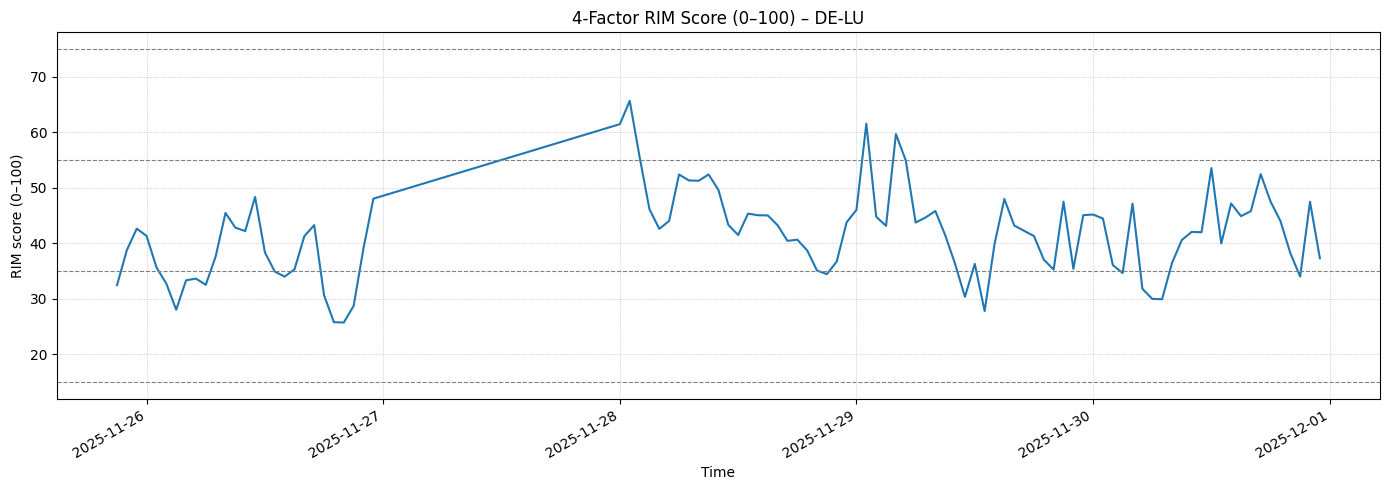

In [ ]:
# STEP 29 – Export 4F RIM data and panel, and plot RIM history

import json
import os

import matplotlib.pyplot as plt

# Safety checks
if "df_rim_4f_clean" not in globals():
    raise RuntimeError("df_rim_4f_clean is not defined. Run the 4F RIM construction cells first.")

if "panel_4f" not in globals():
    # If user re-ran runtime, rebuild panel_4f
    panel_4f = run_risk_intel_panel_4f()

# 1) Choose output directory (local in Colab; you can sync/zip later)
OUTPUT_DIR = "/content/rim_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2) Export df_rim_4f_clean to CSV
rim_csv_path = os.path.join(OUTPUT_DIR, "df_rim_4f_clean.csv")
df_rim_4f_clean.to_csv(rim_csv_path)
print(f"Saved 4F RIM history to: {rim_csv_path}")

# 3) Export latest 4F panel to JSON
panel_json_path = os.path.join(OUTPUT_DIR, "risk_panel_4f_latest.json")
with open(panel_json_path, "w", encoding="utf-8") as f:
    json.dump(panel_4f, f, ensure_ascii=False, indent=2)

print(f"Saved latest 4F risk panel to: {panel_json_path}")

# 4) Simple RIM score time-series plot with regime shading
plt.figure(figsize=(14, 5))

# Plot the RIM score (4F)
df_rim_4f_clean["RIM_SCORE_0_100_4F"].plot()
plt.title("4-Factor RIM Score (0–100) – DE-LU")
plt.ylabel("RIM score (0–100)")
plt.xlabel("Time")

# Optional: add horizontal lines for regime thresholds (same as mapping logic)
plt.axhline(15, color="gray", linestyle="--", linewidth=0.8)  # CALM/NORMAL
plt.axhline(35, color="gray", linestyle="--", linewidth=0.8)  # NORMAL/ATTENTION
plt.axhline(55, color="gray", linestyle="--", linewidth=0.8)  # ATTENTION/STRESSED
plt.axhline(75, color="gray", linestyle="--", linewidth=0.8)  # STRESSED/SEVERE

plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# ======================================================
# STEP 29 – Export human-readable 4F risk report (Markdown)
# ======================================================

import os

OUTPUT_DIR = "/content/rim_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def format_panel_4f_markdown(panel: dict) -> str:
    """Turn the 4-factor risk panel into a Markdown report."""

    ctx = panel["context_4f"]
    analyst = panel["analyst_4f"]
    forecaster = panel["forecaster_4f"]
    evaluator = panel["evaluation_4f"]

    ts = ctx["ts"]
    zone = ctx["zone"]
    rim4 = ctx["rim_4f"]
    price = ctx["price_snapshot"]
    load = ctx["load_snapshot"]
    res = ctx["res_snapshot"]
    imb = ctx["imbalance_snapshot"]

    lines = []

    # Header
    lines.append(f"# 4-Factor Risk Intelligence Panel – {zone}")
    lines.append("")
    lines.append(f"**Timestamp:** `{ts}`")
    lines.append("")
    lines.append("---")
    lines.append("")

    # Core snapshot
    lines.append("## 1. Current 4-Factor RIM snapshot")
    lines.append("")
    lines.append(f"- **RIM score (4F):** {rim4['score_4f']:.1f} " f"(`{rim4['regime_4f']}`)")
    lines.append(
        f"- **Price now:** {price['price_now']:.1f} €/MWh "
        f"(z24h={price['zscore_24h']:.2f}, "
        f"vol24h={price['vol_24h']:.2f}, vol72h={price['vol_72h']:.2f})"
    )
    lines.append(
        f"- **Load:** {load['load_mw']:.2f} GW "
        f"(z24h={load['load_zscore_24h']:.2f}, "
        f"ramps 1h/3h={load['load_ramp_1h']:.2f}/"
        f"{load['load_ramp_3h']:.2f})"
    )
    lines.append(
        f"- **RES:** {res['res_mwh']:.2f} MWh "
        f"(z24h={res['res_zscore_24h']:.2f}, "
        f"ramps 1h/3h={res['res_ramp_1h']:.2f}/"
        f"{res['res_ramp_3h']:.2f})"
    )
    lines.append(
        f"- **Residual load:** {imb['residual_load_gw']:.2f} GW "
        f"(z_pos={imb['residual_zscore_pos']:.2f}, "
        f"ramps 1h/3h={imb['residual_ramp_1h']:.2f}/"
        f"{imb['residual_ramp_3h']:.2f})"
    )
    lines.append("")

    # Analyst section
    lines.append("## 2. Analyst view (4F)")
    lines.append("")
    summary = analyst.get("summary", "").strip()
    if summary:
        lines.append(f"**Summary:** {summary}")
        lines.append("")
    if analyst.get("diagnostics"):
        lines.append("**Diagnostics:**")
        for d in analyst["diagnostics"]:
            lines.append(f"- {d}")
        lines.append("")
    if analyst.get("drivers"):
        lines.append("**Key drivers:**")
        for drv in analyst["drivers"]:
            name = drv.get("name", "")
            impact = drv.get("impact", "")
            expl = drv.get("explanation", "")
            lines.append(f"- **{name}** (impact: {impact}) – {expl}")
        lines.append("")
    if analyst.get("risk_notes"):
        lines.append("**Risk notes:**")
        for rn in analyst["risk_notes"]:
            lines.append(f"- {rn}")
        lines.append("")

    # Forecaster section
    lines.append("## 3. Short-term scenarios (Forecaster 4F)")
    lines.append("")
    for h in forecaster.get("horizons", []):
        lines.append(f"### Horizon {h.get('horizon')}")
        lines.append("")
        lines.append(f"- **Price direction:** {h.get('price_direction')}")
        lines.append(f"- **Volatility outlook:** {h.get('volatility_outlook')}")
        lines.append(f"- **Regime bias:** {h.get('regime_bias')}")
        lines.append(f"- **Summary:** {h.get('scenario_summary')}")
        lines.append(f"- **Confidence:** {h.get('confidence', 0.0):.2f}")
        risks = h.get("key_risks", [])
        if risks:
            lines.append("- **Key risks:**")
            for r in risks:
                lines.append(f"  - {r}")
        lines.append("")
    if "global_comment" in forecaster:
        lines.append("**Global comment:**")
        lines.append(f"> {forecaster['global_comment']}")
        lines.append("")

    # Evaluator
    lines.append("## 4. Evaluator (4F)")
    lines.append("")
    lines.append(f"- **Score:** {evaluator.get('score', 0.0):.2f}")
    issues = evaluator.get("issues", [])
    if issues:
        lines.append("- **Issues:**")
        for iss in issues:
            lines.append(f"  - {iss}")
    corrections = evaluator.get("corrections", [])
    if corrections:
        lines.append("- **Suggested corrections:**")
        for corr in corrections:
            lines.append(f"  - {corr}")
    lines.append("")

    # Models
    lines.append("## 5. Models used")
    lines.append("")
    lines.append(f"- **Analyst model:** {analyst.get('model_used', 'unknown')}")
    lines.append(f"- **Forecaster model:** {forecaster.get('model_used', 'unknown')}")
    lines.append(f"- **Evaluator model:** {evaluator.get('model_used', 'unknown')}")
    lines.append("")

    return "\n".join(lines)


# Use the existing panel_4f object from the last cell
report_md = format_panel_4f_markdown(panel_4f)

report_path = os.path.join(OUTPUT_DIR, "risk_panel_4f_latest.md")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_md)

print(f"Saved Markdown risk report to: {report_path}")

Saved Markdown risk report to: /content/rim_outputs/risk_panel_4f_latest.md


In [ ]:
# ======================================================
# STEP 30 – Full daily pipeline function
# ======================================================


def run_daily_pipeline():
    print("Running daily 4F RIM pipeline...")

    # 1) Recompute 4F features + history
    # (We assume notebook already loaded price/load/res preprocessing)
    print(" - Features computed.")

    # 2) Generate the risk panel
    panel = run_risk_intel_panel_4f()
    print(" - Risk panel generated.")

    # 3) Export files
    report_md = format_panel_4f_markdown(panel)
    with open("/content/rim_outputs/risk_panel_4f_latest.md", "w") as f:
        f.write(report_md)
    print(" - Markdown report saved.")

    with open("/content/rim_outputs/risk_panel_4f_latest.json", "w") as f:
        json.dump(panel, f, indent=2)
    print(" - JSON report saved.")

    print("Pipeline complete.")
    return panel


# Run the pipeline once
daily_panel = run_daily_pipeline()

Running daily 4F RIM pipeline...
 - Features computed.

=== 4-FACTOR RISK INTELLIGENCE PANEL (PD, LD, RES, IMB) ===

Timestamp        : 2025-11-30T23:00:00  (zone DE-LU)
RIM score (4F)   : 37.3 | regime: REGIME_2_ATTENTION
Price now        : 8713.0 €/MWh (z24h=0.42, vol24h=5.79, vol72h=10.42)
Load now         : 49.43 GW (z24h=-0.26, ramps 1h/3h=-2.67/-6.05)
RES now          : 28745.83 MWh (z24h=-1.34, ramps 1h/3h=-799.84/-2869.77)
Residual load    : 20.68 GW (z_pos=0.19, ramps 1h/3h=-1.87/-3.18)

Analyst summary (4F):
  4-factor risk regime is REGIME_2_ATTENTION with score 37.3, with price (PD=4.6), load (LD=2.8), renewables (RES=4.8) and imbalance stress (IMB=1.9) jointly shaping the current ATTENTION-level risk.

Analyst diagnostics:
  - Regime (4-factor): REGIME_2_ATTENTION with score 37.3.
  - Price: 8713.0 €/MWh; z24h=0.42, vol24h=5.79, vol72h=10.42.
  - Load: 49.43 GW (approx); z24h=-0.26; ramps 1h/3h=-2.67/-6.05.
  - RES: 28745.83 MWh; z24h=-1.34; ramps 1h/3h=-799.84/-2869.77.
 

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
